In [4]:
from gamutrf.detection import *
from tqdm import tqdm

In [8]:
np.log10(144)

2.1583624920952498

In [5]:
def spectrogram(samples, sample_rate, nfft, noverlap, min_freq=None, max_freq=None, freq_center=None): 
    # Convert samples into spectrogram
    freq_bins, t_bins, spectrogram = signal.spectrogram(
        samples,
        sample_rate,
        window=signal.windows.hann(int(nfft), sym=True),
        nperseg=nfft,
        noverlap=noverlap,
        detrend='constant',
        return_onesided=False,
    )
    # FFT shift 
    freq_bins = np.fft.fftshift(freq_bins)
    spectrogram = np.fft.fftshift(spectrogram, axes=0)
    # Transpose spectrogram
    spectrogram = spectrogram.T
    spectrogram_raw = spectrogram.copy()
    # dB scale spectrogram
    spectrogram = 10 * np.log10(spectrogram)
    
    # Normalize spectrogram
    spectrogram_normalized = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram)) #(spectrogram - db_min) / (db_max - db_min)
    
    spectrogram_data = spectrogram_normalized

    if min_freq is not None and max_freq is not None and freq_center is not None: 
        if fft_count is None: 
            fft_count = len(t_bins)
        spectrogram_data, max_idx, freq_resolution = prepare_custom_spectrogram(
            min_freq, 
            max_freq, 
            sample_rate, 
            nfft, 
            fft_count, 
            noverlap
        )
        idx = np.array(
            [
                round((item - min_freq) / freq_resolution)
                for item in freq_bins + freq_center
            ]
        ).astype(int)
        spectrogram_data[
            : spectrogram_normalized.shape[0],
            idx[np.flatnonzero((idx >= 0) & (idx <= max_idx))],
        ] = spectrogram_normalized[:, np.flatnonzero((idx >= 0) & (idx <= max_idx))]
        
    return spectrogram_data, spectrogram_raw

def spectrogram_cmap(spectrogram_data, cmap): 
    # Spectrogram color transforms 
    #spectrogram_color = cv2.resize(cmap(spectrogram_data)[:,:,:3], dsize=(1640, 640), interpolation=cv2.INTER_CUBIC)[:,:,::-1]
    spectrogram_color = cmap(spectrogram_data)[:,:,:3] # remove alpha dimension
    spectrogram_color = spectrogram_color[::-1,:,:] # flip vertically
    spectrogram_color *= 255
    spectrogram_color = spectrogram_color.astype(int)
    spectrogram_color = np.ascontiguousarray(spectrogram_color, dtype=np.uint8)
    return spectrogram_color

In [87]:
# ARG PARSE PARAMETERS
sample_dir = "/Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/"
save_dir = Path(sample_dir, "snr_noise_floor")
nfft = 1024
mini_batch_size = 1024*512
fft_count = None
save_data = True
skip_inference = True
min_freq = None
max_freq = None
    
if (min_freq is None and max_freq is not None) or (min_freq is not None and max_freq is None): 
    print("Error! If min_freq or max_freq is defined then both must be defined. Exiting.")
    exit()
if min_freq is not None and max_freq is not None: 
    custom_spectrogram = True
else: 
    custom_spectrogram = False

noverlap = 0 #nfft // 8
model = None
cmap = plt.get_cmap("turbo")


spectrogram_id = 0 
processed_files = []

wait_count = 0 
wait_time = 1
wait_count_limit = 5

while True:
    unprocessed_files = [
        basefilename
        for basefilename in sorted(os.listdir(sample_dir))
        if os.path.isfile(os.path.join(sample_dir, basefilename)) 
        and supported_filetype(basefilename)
        and basefilename not in processed_files
    ]

    # Process files
    if unprocessed_files:

        meta_data = {}

        for basefilename in unprocessed_files: 
            unprocessed_files.remove(basefilename)
            
            # Load samples 
            file_info = parse_filename(os.path.join(sample_dir, basefilename))
            if file_info is None: 
                continue
                
            samples = read_samples(
                file_info["filename"], 
                file_info["sample_dtype"], 
                file_info["sample_len"], 
                seek_bytes=0, 
                nfft=nfft, 
                fft_count=fft_count,
            )
            if samples is None:
                print("Continuing...")
                continue
            processed_files.append(basefilename)
            print(f"Recording duration: {len(samples)/file_info['sample_rate']} seconds")

            # DO BATCHING HERE 
            
            if mini_batch_size is None:
                mini_batch_size = len(samples)
            batch_id = 0
            
            for idx in tqdm(range(0, len(samples), mini_batch_size)): 
                sample_start_idx = idx
                sample_end_idx = idx+mini_batch_size
                sample_batch = samples[sample_start_idx:sample_end_idx]

                print(f"Batch duration: {len(sample_batch)/file_info['sample_rate']} seconds")

                snr_range = [None, -10, -5, 0, 5, 10, 20, 30] 
                for snr in snr_range: 
                    sample_data = sample_batch

                    if snr: 
                        ###
        
                        avg_power_db = 10 * np.log10(np.mean(np.abs(sample_data)**2))
                        target_snr_db = snr
                        target_noise_db = avg_power_db - target_snr_db
        
                        # Convert to linear Watt units
                        target_noise_watts = 10 ** (target_noise_db / 10)
                        
                        # Generate noise samples
                        mean_noise = 0
                        noise_volts = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(sample_data))
                        
                        # Noise up the original signal (again) and plot
                        sample_data = sample_data + noise_volts
        
                        ###
                    
                    spectrogram_data, spectrogram_raw = spectrogram(
                        sample_data, 
                        file_info["sample_rate"], 
                        nfft, 
                        noverlap, 
                        min_freq=min_freq, 
                        max_freq=max_freq, 
                        freq_center=file_info["freq_center"]
                    )
                    spectrogram_color = spectrogram_cmap(
                        spectrogram_data, 
                        cmap
                    )
        
                    
                    if save_data or not skip_inference: 
    
                        batchstr = ""
                        if mini_batch_size != len(samples): 
                            batchstr = f"_batch{batch_id}"
                            
                        savefilename = f"{basefilename}_id{spectrogram_id}{batchstr}"
                        
                        # Save spectrogram as .png
                        if save_data: 
                            spectrogram_img = Image.fromarray(spectrogram_color)
                            image_dir = Path(save_dir, "png")
                            image_dir.mkdir(parents=True, exist_ok=True)
                            image_path = image_dir / f"{savefilename}.png"
                            spectrogram_img.save(image_path)
                            meta_data["img_file"] = str(image_path)
                            print("Saved image to "+str(image_path))
                
                        # Run inference model
                        if not skip_inference:
                            if model is None: 
                                model = YOLO("/home/ltindall/ultralytics/runs/detect/yolov8s_exp_v05/weights/best.pt")
                            if spectrogram_id > 0: # bug in yolov8, name parameters is broken in predict()
                                model.predictor.save_dir = Path(save_dir, "predictions", savefilename) 
                            results = model.predict(source=spectrogram_color[:,:,::-1], conf=0.05, save=True, save_txt=True, save_conf=True, project=f"{save_dir}/predictions/", name=f"{savefilename}", exist_ok=True)
            
                        # Save metadata as .json 
                        meta_data["id"] = spectrogram_id
                        meta_data["nfft"] = nfft
                        meta_data["snr"] = snr
                        meta_data["sample_start_idx"] = sample_start_idx
                        meta_data["sample_end_idx"] = sample_end_idx
                        meta_data["mini_batch_size"] = mini_batch_size
                        meta_data["sample_file"] = file_info
                        meta_dir = Path(save_dir, "metadata")
                        meta_dir.mkdir(parents=True, exist_ok=True)
                        json_object = json.dumps(meta_data, indent=4, cls=DtypeEncoder)
                        meta_data_path = meta_dir / f"{savefilename}.json"
                        with open(meta_data_path, "w") as outfile:
                            outfile.write(json_object)
                        print("Saved metadata to "+str(meta_data_path))
                    batch_id += 1
                    spectrogram_id += 1    

    else:
        print("Waiting for sample files to process...")
        time.sleep(wait_time)
        wait_count += 1
        if wait_count == wait_count_limit: 
            print(f"No samples found for {wait_time*wait_count_limit} seconds. Exiting.")
            break

Reading /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst
Recording duration: 1.024 seconds


  0%|                                                       | 0/40 [00:00<?, ?it/s]

Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id0_batch0.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id0_batch0.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id1_batch1.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id1_batch1.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id2_batch2.png
Saved metadata to /Users/ltindall/data/ga

  2%|█▏                                             | 1/40 [00:01<00:42,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id7_batch7.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id7_batch7.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id8_batch8.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id8_batch8.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id9_batch9.png
Saved metadata to /Users/ltindall/data/ga

  5%|██▎                                            | 2/40 [00:02<00:41,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id15_batch15.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id15_batch15.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id16_batch16.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id16_batch16.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id17_batch17.png
Saved metadata to /Users/ltinda

  8%|███▌                                           | 3/40 [00:03<00:40,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id23_batch23.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id23_batch23.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id24_batch24.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id24_batch24.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id25_batch25.png
Saved metadata to /Users/ltinda

 10%|████▋                                          | 4/40 [00:04<00:39,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id31_batch31.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id31_batch31.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id32_batch32.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id32_batch32.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id33_batch33.png
Saved metadata to /Users/ltinda

 12%|█████▉                                         | 5/40 [00:05<00:38,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id39_batch39.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id39_batch39.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id40_batch40.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id40_batch40.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id41_batch41.png
Saved metadata to /Users/ltinda

 15%|███████                                        | 6/40 [00:06<00:37,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id46_batch46.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id46_batch46.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id47_batch47.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id47_batch47.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id48_batch48.png
Saved metadata to /Users/ltinda

 18%|████████▏                                      | 7/40 [00:07<00:36,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id54_batch54.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id54_batch54.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id55_batch55.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id55_batch55.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id56_batch56.png
Saved metadata to /Users/ltinda

 20%|█████████▍                                     | 8/40 [00:08<00:35,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id62_batch62.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id62_batch62.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id63_batch63.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id63_batch63.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id64_batch64.png
Saved metadata to /Users/ltinda

 22%|██████████▌                                    | 9/40 [00:09<00:33,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id70_batch70.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id70_batch70.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id71_batch71.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id71_batch71.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id72_batch72.png
Saved metadata to /Users/ltinda

 25%|███████████▌                                  | 10/40 [00:10<00:32,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id78_batch78.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id78_batch78.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id79_batch79.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id79_batch79.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id80_batch80.png
Saved metadata to /Users/ltinda

 28%|████████████▋                                 | 11/40 [00:11<00:31,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id86_batch86.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id86_batch86.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id87_batch87.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id87_batch87.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id88_batch88.png
Saved metadata to /Users/ltinda

 30%|█████████████▊                                | 12/40 [00:13<00:30,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id94_batch94.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id94_batch94.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id95_batch95.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id95_batch95.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id96_batch96.png
Saved metadata to /Users/ltinda

 32%|██████████████▉                               | 13/40 [00:14<00:29,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id102_batch102.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id102_batch102.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id103_batch103.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id103_batch103.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id104_batch104.png
Saved metadata to /Us

 35%|████████████████                              | 14/40 [00:15<00:28,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id110_batch110.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id110_batch110.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id111_batch111.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id111_batch111.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id112_batch112.png
Saved metadata to /Us

 38%|█████████████████▎                            | 15/40 [00:16<00:27,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id118_batch118.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id118_batch118.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id119_batch119.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id119_batch119.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id120_batch120.png
Saved metadata to /Us

 40%|██████████████████▍                           | 16/40 [00:17<00:25,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id126_batch126.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id126_batch126.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id127_batch127.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id127_batch127.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id128_batch128.png
Saved metadata to /Us

 42%|███████████████████▌                          | 17/40 [00:18<00:24,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id134_batch134.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id134_batch134.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id135_batch135.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id135_batch135.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id136_batch136.png
Saved metadata to /Us

 45%|████████████████████▋                         | 18/40 [00:19<00:23,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id142_batch142.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id142_batch142.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id143_batch143.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id143_batch143.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id144_batch144.png
Saved metadata to /Us

 48%|█████████████████████▊                        | 19/40 [00:20<00:22,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id150_batch150.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id150_batch150.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id151_batch151.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id151_batch151.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id152_batch152.png
Saved metadata to /Us

 50%|███████████████████████                       | 20/40 [00:21<00:21,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id158_batch158.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id158_batch158.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id159_batch159.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id159_batch159.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id160_batch160.png
Saved metadata to /Us

 52%|████████████████████████▏                     | 21/40 [00:22<00:20,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id166_batch166.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id166_batch166.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id167_batch167.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id167_batch167.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id168_batch168.png
Saved metadata to /Us

 55%|█████████████████████████▎                    | 22/40 [00:23<00:19,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id174_batch174.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id174_batch174.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id175_batch175.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id175_batch175.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id176_batch176.png
Saved metadata to /Us

 57%|██████████████████████████▍                   | 23/40 [00:24<00:18,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id182_batch182.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id182_batch182.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id183_batch183.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id183_batch183.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id184_batch184.png
Saved metadata to /Us

 60%|███████████████████████████▌                  | 24/40 [00:26<00:17,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id190_batch190.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id190_batch190.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id191_batch191.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id191_batch191.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id192_batch192.png
Saved metadata to /Us

 62%|████████████████████████████▊                 | 25/40 [00:27<00:16,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id198_batch198.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id198_batch198.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id199_batch199.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id199_batch199.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id200_batch200.png
Saved metadata to /Us

 65%|█████████████████████████████▉                | 26/40 [00:28<00:15,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id206_batch206.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id206_batch206.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id207_batch207.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id207_batch207.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id208_batch208.png
Saved metadata to /Us

 68%|███████████████████████████████               | 27/40 [00:29<00:14,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id214_batch214.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id214_batch214.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id215_batch215.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id215_batch215.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id216_batch216.png
Saved metadata to /Us

 70%|████████████████████████████████▏             | 28/40 [00:30<00:13,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id222_batch222.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id222_batch222.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id223_batch223.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id223_batch223.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id224_batch224.png
Saved metadata to /Us

 72%|█████████████████████████████████▎            | 29/40 [00:31<00:11,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id230_batch230.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id230_batch230.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id231_batch231.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id231_batch231.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id232_batch232.png
Saved metadata to /Us

 75%|██████████████████████████████████▌           | 30/40 [00:32<00:10,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id238_batch238.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id238_batch238.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id239_batch239.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id239_batch239.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id240_batch240.png
Saved metadata to /Us

 78%|███████████████████████████████████▋          | 31/40 [00:33<00:09,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id246_batch246.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id246_batch246.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id247_batch247.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id247_batch247.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id248_batch248.png
Saved metadata to /Us

 80%|████████████████████████████████████▊         | 32/40 [00:34<00:08,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id254_batch254.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id254_batch254.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id255_batch255.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id255_batch255.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id256_batch256.png
Saved metadata to /Us

 82%|█████████████████████████████████████▉        | 33/40 [00:35<00:07,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id262_batch262.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id262_batch262.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id263_batch263.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id263_batch263.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id264_batch264.png
Saved metadata to /Us

 85%|███████████████████████████████████████       | 34/40 [00:36<00:06,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id270_batch270.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id270_batch270.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id271_batch271.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id271_batch271.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id272_batch272.png
Saved metadata to /Us

 88%|████████████████████████████████████████▎     | 35/40 [00:37<00:05,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id278_batch278.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id278_batch278.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id279_batch279.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id279_batch279.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id280_batch280.png
Saved metadata to /Us

 90%|█████████████████████████████████████████▍    | 36/40 [00:38<00:04,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id286_batch286.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id286_batch286.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id287_batch287.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id287_batch287.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id288_batch288.png
Saved metadata to /Us

 92%|██████████████████████████████████████████▌   | 37/40 [00:40<00:03,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id294_batch294.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id294_batch294.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id295_batch295.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id295_batch295.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id296_batch296.png
Saved metadata to /Us

 95%|███████████████████████████████████████████▋  | 38/40 [00:41<00:02,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id302_batch302.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id302_batch302.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id303_batch303.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id303_batch303.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id304_batch304.png
Saved metadata to /Us

 98%|████████████████████████████████████████████▊ | 39/40 [00:42<00:01,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id310_batch310.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id310_batch310.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id311_batch311.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id311_batch311.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id312_batch312.png
Saved metadata to /Us

100%|██████████████████████████████████████████████| 40/40 [00:43<00:00,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id318_batch318.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id318_batch318.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id319_batch319.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id319_batch319.json
Reading /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst


Recording duration: 1.024 seconds


  0%|                                                       | 0/40 [00:00<?, ?it/s]

Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id320_batch0.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id320_batch0.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id321_batch1.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id321_batch1.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id322_batch2.png
Saved metadata to /Users/ltinda

  2%|█▏                                             | 1/40 [00:01<00:43,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id327_batch7.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id327_batch7.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id328_batch8.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id328_batch8.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id329_batch9.png
Saved metadata to /Users/ltinda

  5%|██▎                                            | 2/40 [00:02<00:41,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id335_batch15.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id335_batch15.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id336_batch16.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id336_batch16.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id337_batch17.png
Saved metadata to /Users/l

  8%|███▌                                           | 3/40 [00:03<00:40,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id343_batch23.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id343_batch23.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id344_batch24.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id344_batch24.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id345_batch25.png
Saved metadata to /Users/l

 10%|████▋                                          | 4/40 [00:04<00:39,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id351_batch31.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id351_batch31.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id352_batch32.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id352_batch32.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id353_batch33.png
Saved metadata to /Users/l

 12%|█████▉                                         | 5/40 [00:05<00:38,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id359_batch39.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id359_batch39.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id360_batch40.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id360_batch40.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id361_batch41.png
Saved metadata to /Users/l

 15%|███████                                        | 6/40 [00:06<00:37,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id367_batch47.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id367_batch47.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id368_batch48.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id368_batch48.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id369_batch49.png
Saved metadata to /Users/l

 18%|████████▏                                      | 7/40 [00:07<00:36,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id375_batch55.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id375_batch55.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id376_batch56.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id376_batch56.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id377_batch57.png
Saved metadata to /Users/l

 20%|█████████▍                                     | 8/40 [00:08<00:35,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id383_batch63.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id383_batch63.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id384_batch64.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id384_batch64.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id385_batch65.png
Saved metadata to /Users/l

 22%|██████████▌                                    | 9/40 [00:09<00:34,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id391_batch71.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id391_batch71.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id392_batch72.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id392_batch72.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id393_batch73.png
Saved metadata to /Users/l

 25%|███████████▌                                  | 10/40 [00:11<00:33,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id399_batch79.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id399_batch79.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id400_batch80.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id400_batch80.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id401_batch81.png
Saved metadata to /Users/l

 28%|████████████▋                                 | 11/40 [00:12<00:32,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id407_batch87.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id407_batch87.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id408_batch88.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id408_batch88.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id409_batch89.png
Saved metadata to /Users/l

 30%|█████████████▊                                | 12/40 [00:13<00:31,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id415_batch95.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id415_batch95.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id416_batch96.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id416_batch96.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id417_batch97.png
Saved metadata to /Users/l

 32%|██████████████▉                               | 13/40 [00:14<00:30,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id423_batch103.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id423_batch103.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id424_batch104.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id424_batch104.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id425_batch105.png
Saved metadata to /Us

 35%|████████████████                              | 14/40 [00:15<00:28,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id431_batch111.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id431_batch111.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id432_batch112.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id432_batch112.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id433_batch113.png
Saved metadata to /Us

 38%|█████████████████▎                            | 15/40 [00:16<00:27,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id439_batch119.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id439_batch119.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id440_batch120.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id440_batch120.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id441_batch121.png
Saved metadata to /Us

 40%|██████████████████▍                           | 16/40 [00:17<00:26,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id447_batch127.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id447_batch127.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id448_batch128.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id448_batch128.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id449_batch129.png
Saved metadata to /Us

 42%|███████████████████▌                          | 17/40 [00:18<00:25,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id455_batch135.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id455_batch135.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id456_batch136.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id456_batch136.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id457_batch137.png
Saved metadata to /Us

 45%|████████████████████▋                         | 18/40 [00:19<00:24,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id463_batch143.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id463_batch143.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id464_batch144.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id464_batch144.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id465_batch145.png
Saved metadata to /Us

 48%|█████████████████████▊                        | 19/40 [00:21<00:23,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id471_batch151.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id471_batch151.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id472_batch152.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id472_batch152.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id473_batch153.png
Saved metadata to /Us

 50%|███████████████████████                       | 20/40 [00:22<00:22,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id479_batch159.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id479_batch159.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id480_batch160.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id480_batch160.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id481_batch161.png
Saved metadata to /Us

 52%|████████████████████████▏                     | 21/40 [00:23<00:21,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id487_batch167.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id487_batch167.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id488_batch168.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id488_batch168.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id489_batch169.png
Saved metadata to /Us

 55%|█████████████████████████▎                    | 22/40 [00:24<00:19,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id495_batch175.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id495_batch175.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id496_batch176.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id496_batch176.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id497_batch177.png
Saved metadata to /Us

 57%|██████████████████████████▍                   | 23/40 [00:25<00:18,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id503_batch183.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id503_batch183.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id504_batch184.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id504_batch184.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id505_batch185.png
Saved metadata to /Us

 60%|███████████████████████████▌                  | 24/40 [00:26<00:17,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id511_batch191.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id511_batch191.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id512_batch192.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id512_batch192.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id513_batch193.png
Saved metadata to /Us

 62%|████████████████████████████▊                 | 25/40 [00:27<00:16,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id519_batch199.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id519_batch199.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id520_batch200.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id520_batch200.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id521_batch201.png
Saved metadata to /Us

 65%|█████████████████████████████▉                | 26/40 [00:28<00:15,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id527_batch207.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id527_batch207.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id528_batch208.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id528_batch208.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id529_batch209.png
Saved metadata to /Us

 68%|███████████████████████████████               | 27/40 [00:29<00:14,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id535_batch215.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id535_batch215.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id536_batch216.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id536_batch216.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id537_batch217.png
Saved metadata to /Us

 70%|████████████████████████████████▏             | 28/40 [00:31<00:13,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id543_batch223.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id543_batch223.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id544_batch224.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id544_batch224.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id545_batch225.png
Saved metadata to /Us

 72%|█████████████████████████████████▎            | 29/40 [00:32<00:12,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id551_batch231.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id551_batch231.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id552_batch232.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id552_batch232.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id553_batch233.png
Saved metadata to /Us

 75%|██████████████████████████████████▌           | 30/40 [00:33<00:11,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id559_batch239.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id559_batch239.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id560_batch240.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id560_batch240.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id561_batch241.png
Saved metadata to /Us

 78%|███████████████████████████████████▋          | 31/40 [00:34<00:10,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id567_batch247.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id567_batch247.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id568_batch248.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id568_batch248.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id569_batch249.png
Saved metadata to /Us

 80%|████████████████████████████████████▊         | 32/40 [00:35<00:08,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id575_batch255.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id575_batch255.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id576_batch256.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id576_batch256.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id577_batch257.png
Saved metadata to /Us

 82%|█████████████████████████████████████▉        | 33/40 [00:36<00:07,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id583_batch263.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id583_batch263.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id584_batch264.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id584_batch264.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id585_batch265.png
Saved metadata to /Us

 85%|███████████████████████████████████████       | 34/40 [00:37<00:06,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id591_batch271.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id591_batch271.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id592_batch272.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id592_batch272.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id593_batch273.png
Saved metadata to /Us

 88%|████████████████████████████████████████▎     | 35/40 [00:38<00:05,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id599_batch279.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id599_batch279.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id600_batch280.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id600_batch280.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id601_batch281.png
Saved metadata to /Us

 90%|█████████████████████████████████████████▍    | 36/40 [00:39<00:04,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id607_batch287.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id607_batch287.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id608_batch288.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id608_batch288.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id609_batch289.png
Saved metadata to /Us

 92%|██████████████████████████████████████████▌   | 37/40 [00:41<00:03,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id615_batch295.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id615_batch295.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id616_batch296.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id616_batch296.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id617_batch297.png
Saved metadata to /Us

 95%|███████████████████████████████████████████▋  | 38/40 [00:42<00:02,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id623_batch303.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id623_batch303.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id624_batch304.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id624_batch304.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id625_batch305.png
Saved metadata to /Us

 98%|████████████████████████████████████████████▊ | 39/40 [00:43<00:01,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id631_batch311.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id631_batch311.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id632_batch312.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id632_batch312.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id633_batch313.png
Saved metadata to /Us

100%|██████████████████████████████████████████████| 40/40 [00:44<00:00,  1.11s/it]


Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id639_batch319.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id639_batch319.json
Reading /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst
Recording duration: 1.024 seconds


  0%|                                                       | 0/40 [00:00<?, ?it/s]

Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id640_batch0.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id640_batch0.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id641_batch1.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id641_batch1.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id642_batch2.png
Saved metadata to /Users/ltinda

  2%|█▏                                             | 1/40 [00:01<00:41,  1.07s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id647_batch7.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id647_batch7.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id648_batch8.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id648_batch8.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id649_batch9.png
Saved metadata to /Users/ltinda

  5%|██▎                                            | 2/40 [00:02<00:41,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id655_batch15.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id655_batch15.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id656_batch16.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id656_batch16.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id657_batch17.png
Saved metadata to /Users/l

  8%|███▌                                           | 3/40 [00:03<00:40,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id663_batch23.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id663_batch23.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id664_batch24.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id664_batch24.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id665_batch25.png
Saved metadata to /Users/l

 10%|████▋                                          | 4/40 [00:04<00:39,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id671_batch31.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id671_batch31.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id672_batch32.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id672_batch32.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id673_batch33.png
Saved metadata to /Users/l

 12%|█████▉                                         | 5/40 [00:05<00:38,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id679_batch39.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id679_batch39.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id680_batch40.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id680_batch40.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id681_batch41.png
Saved metadata to /Users/l

 15%|███████                                        | 6/40 [00:06<00:37,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id687_batch47.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id687_batch47.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id688_batch48.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id688_batch48.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id689_batch49.png
Saved metadata to /Users/l

 18%|████████▏                                      | 7/40 [00:07<00:36,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id695_batch55.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id695_batch55.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id696_batch56.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id696_batch56.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id697_batch57.png
Saved metadata to /Users/l

 20%|█████████▍                                     | 8/40 [00:08<00:35,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id703_batch63.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id703_batch63.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id704_batch64.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id704_batch64.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id705_batch65.png
Saved metadata to /Users/l

 22%|██████████▌                                    | 9/40 [00:09<00:34,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id711_batch71.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id711_batch71.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id712_batch72.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id712_batch72.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id713_batch73.png
Saved metadata to /Users/l

 25%|███████████▌                                  | 10/40 [00:10<00:33,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id719_batch79.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id719_batch79.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id720_batch80.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id720_batch80.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id721_batch81.png
Saved metadata to /Users/l

 28%|████████████▋                                 | 11/40 [00:12<00:32,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id727_batch87.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id727_batch87.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id728_batch88.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id728_batch88.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id729_batch89.png
Saved metadata to /Users/l

 30%|█████████████▊                                | 12/40 [00:13<00:30,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id735_batch95.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id735_batch95.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id736_batch96.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id736_batch96.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id737_batch97.png
Saved metadata to /Users/l

 32%|██████████████▉                               | 13/40 [00:14<00:29,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id743_batch103.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id743_batch103.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id744_batch104.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id744_batch104.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id745_batch105.png
Saved metadata to /Us

 35%|████████████████                              | 14/40 [00:15<00:28,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id751_batch111.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id751_batch111.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id752_batch112.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id752_batch112.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id753_batch113.png
Saved metadata to /Us

 38%|█████████████████▎                            | 15/40 [00:16<00:28,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id759_batch119.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id759_batch119.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id760_batch120.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id760_batch120.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id761_batch121.png
Saved metadata to /Us

 40%|██████████████████▍                           | 16/40 [00:18<00:29,  1.21s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id767_batch127.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id767_batch127.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id768_batch128.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id768_batch128.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id769_batch129.png
Saved metadata to /Us

 42%|███████████████████▌                          | 17/40 [00:19<00:27,  1.18s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id775_batch135.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id775_batch135.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id776_batch136.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id776_batch136.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id777_batch137.png
Saved metadata to /Us

 45%|████████████████████▋                         | 18/40 [00:20<00:25,  1.15s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id783_batch143.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id783_batch143.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id784_batch144.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id784_batch144.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id785_batch145.png
Saved metadata to /Us

 48%|█████████████████████▊                        | 19/40 [00:21<00:23,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id791_batch151.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id791_batch151.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id792_batch152.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id792_batch152.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id793_batch153.png
Saved metadata to /Us

 50%|███████████████████████                       | 20/40 [00:22<00:22,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id799_batch159.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id799_batch159.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id800_batch160.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id800_batch160.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id801_batch161.png
Saved metadata to /Us

 52%|████████████████████████▏                     | 21/40 [00:23<00:20,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id807_batch167.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id807_batch167.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id808_batch168.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id808_batch168.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id809_batch169.png
Saved metadata to /Us

 55%|█████████████████████████▎                    | 22/40 [00:24<00:19,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id815_batch175.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id815_batch175.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id816_batch176.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id816_batch176.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id817_batch177.png
Saved metadata to /Us

 57%|██████████████████████████▍                   | 23/40 [00:25<00:18,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id823_batch183.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id823_batch183.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id824_batch184.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id824_batch184.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id825_batch185.png
Saved metadata to /Us

 60%|███████████████████████████▌                  | 24/40 [00:26<00:17,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id831_batch191.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id831_batch191.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id832_batch192.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id832_batch192.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id833_batch193.png
Saved metadata to /Us

 62%|████████████████████████████▊                 | 25/40 [00:27<00:16,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id839_batch199.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id839_batch199.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id840_batch200.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id840_batch200.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id841_batch201.png
Saved metadata to /Us

 65%|█████████████████████████████▉                | 26/40 [00:28<00:15,  1.10s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id847_batch207.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id847_batch207.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id848_batch208.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id848_batch208.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id849_batch209.png
Saved metadata to /Us

 68%|███████████████████████████████               | 27/40 [00:29<00:14,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id855_batch215.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id855_batch215.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id856_batch216.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id856_batch216.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id857_batch217.png
Saved metadata to /Us

 70%|████████████████████████████████▏             | 28/40 [00:31<00:13,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id863_batch223.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id863_batch223.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id864_batch224.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id864_batch224.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id865_batch225.png
Saved metadata to /Us

 72%|█████████████████████████████████▎            | 29/40 [00:32<00:11,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id871_batch231.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id871_batch231.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id872_batch232.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id872_batch232.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id873_batch233.png
Saved metadata to /Us

 75%|██████████████████████████████████▌           | 30/40 [00:33<00:10,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id879_batch239.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id879_batch239.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id880_batch240.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id880_batch240.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id881_batch241.png
Saved metadata to /Us

 78%|███████████████████████████████████▋          | 31/40 [00:34<00:09,  1.08s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id887_batch247.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id887_batch247.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id888_batch248.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id888_batch248.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id889_batch249.png
Saved metadata to /Us

 80%|████████████████████████████████████▊         | 32/40 [00:35<00:08,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id895_batch255.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id895_batch255.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id896_batch256.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id896_batch256.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id897_batch257.png
Saved metadata to /Us

 82%|█████████████████████████████████████▉        | 33/40 [00:36<00:07,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id903_batch263.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id903_batch263.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id904_batch264.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id904_batch264.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id905_batch265.png
Saved metadata to /Us

 85%|███████████████████████████████████████       | 34/40 [00:37<00:06,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id911_batch271.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id911_batch271.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id912_batch272.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id912_batch272.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id913_batch273.png
Saved metadata to /Us

 88%|████████████████████████████████████████▎     | 35/40 [00:38<00:05,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id919_batch279.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id919_batch279.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id920_batch280.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id920_batch280.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id921_batch281.png
Saved metadata to /Us

 90%|█████████████████████████████████████████▍    | 36/40 [00:39<00:04,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id927_batch287.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id927_batch287.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id928_batch288.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id928_batch288.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id929_batch289.png
Saved metadata to /Us

 92%|██████████████████████████████████████████▌   | 37/40 [00:40<00:03,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id935_batch295.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id935_batch295.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id936_batch296.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id936_batch296.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id937_batch297.png
Saved metadata to /Us

 95%|███████████████████████████████████████████▋  | 38/40 [00:41<00:02,  1.09s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id943_batch303.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id943_batch303.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id944_batch304.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id944_batch304.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id945_batch305.png
Saved metadata to /Us

 98%|████████████████████████████████████████████▊ | 39/40 [00:43<00:01,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id951_batch311.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id951_batch311.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id952_batch312.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id952_batch312.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id953_batch313.png
Saved metadata to /Us

100%|██████████████████████████████████████████████| 40/40 [00:44<00:00,  1.11s/it]


Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id959_batch319.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id959_batch319.json
Reading /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst
Recording duration: 1.024 seconds


  0%|                                                       | 0/40 [00:00<?, ?it/s]

Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id960_batch0.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id960_batch0.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id961_batch1.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id961_batch1.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id962_batch2.png
Saved metadata to /Users/ltinda

  2%|█▏                                             | 1/40 [00:01<00:43,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id967_batch7.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id967_batch7.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id968_batch8.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id968_batch8.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id969_batch9.png
Saved metadata to /Users/ltinda

  5%|██▎                                            | 2/40 [00:02<00:42,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id975_batch15.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id975_batch15.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id976_batch16.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id976_batch16.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id977_batch17.png
Saved metadata to /Users/l

  8%|███▌                                           | 3/40 [00:03<00:41,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id983_batch23.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id983_batch23.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id984_batch24.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id984_batch24.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id985_batch25.png
Saved metadata to /Users/l

 10%|████▋                                          | 4/40 [00:04<00:40,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id991_batch31.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id991_batch31.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id992_batch32.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id992_batch32.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id993_batch33.png
Saved metadata to /Users/l

 12%|█████▉                                         | 5/40 [00:05<00:39,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id999_batch39.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id999_batch39.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1000_batch40.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1000_batch40.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1001_batch41.png
Saved metadata to /User

 15%|███████                                        | 6/40 [00:06<00:37,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1007_batch47.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1007_batch47.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1008_batch48.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1008_batch48.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1009_batch49.png
Saved metadata to /Us

 18%|████████▏                                      | 7/40 [00:07<00:36,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1015_batch55.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1015_batch55.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1016_batch56.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1016_batch56.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1017_batch57.png
Saved metadata to /Us

 20%|█████████▍                                     | 8/40 [00:09<00:39,  1.22s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1022_batch62.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1022_batch62.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1023_batch63.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1023_batch63.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1024_batch64.png
Saved metadata to /Us

 22%|██████████▌                                    | 9/40 [00:10<00:37,  1.20s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1030_batch70.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1030_batch70.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1031_batch71.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1031_batch71.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1032_batch72.png
Saved metadata to /Us

 25%|███████████▌                                  | 10/40 [00:11<00:35,  1.18s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1038_batch78.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1038_batch78.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1039_batch79.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1039_batch79.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1040_batch80.png
Saved metadata to /Us

 28%|████████████▋                                 | 11/40 [00:12<00:33,  1.16s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1046_batch86.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1046_batch86.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1047_batch87.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1047_batch87.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1048_batch88.png
Saved metadata to /Us

 30%|█████████████▊                                | 12/40 [00:13<00:32,  1.15s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1054_batch94.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1054_batch94.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1055_batch95.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1055_batch95.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1056_batch96.png
Saved metadata to /Us

 32%|██████████████▉                               | 13/40 [00:14<00:30,  1.15s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1062_batch102.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1062_batch102.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1063_batch103.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1063_batch103.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1064_batch104.png
Saved metadata t

 35%|████████████████                              | 14/40 [00:16<00:29,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1070_batch110.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1070_batch110.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1071_batch111.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1071_batch111.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1072_batch112.png
Saved metadata t

 38%|█████████████████▎                            | 15/40 [00:17<00:28,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1078_batch118.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1078_batch118.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1079_batch119.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1079_batch119.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1080_batch120.png
Saved metadata t

 40%|██████████████████▍                           | 16/40 [00:18<00:27,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1086_batch126.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1086_batch126.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1087_batch127.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1087_batch127.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1088_batch128.png
Saved metadata t

 42%|███████████████████▌                          | 17/40 [00:19<00:26,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1094_batch134.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1094_batch134.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1095_batch135.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1095_batch135.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1096_batch136.png
Saved metadata t

 45%|████████████████████▋                         | 18/40 [00:20<00:24,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1102_batch142.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1102_batch142.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1103_batch143.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1103_batch143.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1104_batch144.png
Saved metadata t

 48%|█████████████████████▊                        | 19/40 [00:21<00:23,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1110_batch150.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1110_batch150.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1111_batch151.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1111_batch151.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1112_batch152.png
Saved metadata t

 50%|███████████████████████                       | 20/40 [00:22<00:22,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1118_batch158.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1118_batch158.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1119_batch159.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1119_batch159.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1120_batch160.png
Saved metadata t

 52%|████████████████████████▏                     | 21/40 [00:23<00:21,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1126_batch166.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1126_batch166.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1127_batch167.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1127_batch167.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1128_batch168.png
Saved metadata t

 55%|█████████████████████████▎                    | 22/40 [00:25<00:20,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1134_batch174.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1134_batch174.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1135_batch175.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1135_batch175.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1136_batch176.png
Saved metadata t

 57%|██████████████████████████▍                   | 23/40 [00:26<00:19,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1142_batch182.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1142_batch182.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1143_batch183.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1143_batch183.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1144_batch184.png
Saved metadata t

 60%|███████████████████████████▌                  | 24/40 [00:27<00:17,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1150_batch190.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1150_batch190.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1151_batch191.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1151_batch191.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1152_batch192.png
Saved metadata t

 62%|████████████████████████████▊                 | 25/40 [00:28<00:16,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1158_batch198.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1158_batch198.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1159_batch199.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1159_batch199.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1160_batch200.png
Saved metadata t

 65%|█████████████████████████████▉                | 26/40 [00:29<00:15,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1166_batch206.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1166_batch206.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1167_batch207.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1167_batch207.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1168_batch208.png
Saved metadata t

 68%|███████████████████████████████               | 27/40 [00:30<00:14,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1174_batch214.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1174_batch214.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1175_batch215.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1175_batch215.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1176_batch216.png
Saved metadata t

 70%|████████████████████████████████▏             | 28/40 [00:31<00:13,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1182_batch222.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1182_batch222.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1183_batch223.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1183_batch223.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1184_batch224.png
Saved metadata t

 72%|█████████████████████████████████▎            | 29/40 [00:32<00:12,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1190_batch230.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1190_batch230.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1191_batch231.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1191_batch231.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1192_batch232.png
Saved metadata t

 75%|██████████████████████████████████▌           | 30/40 [00:34<00:11,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1198_batch238.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1198_batch238.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1199_batch239.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1199_batch239.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1200_batch240.png
Saved metadata t

 78%|███████████████████████████████████▋          | 31/40 [00:35<00:10,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1206_batch246.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1206_batch246.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1207_batch247.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1207_batch247.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1208_batch248.png
Saved metadata t

 80%|████████████████████████████████████▊         | 32/40 [00:36<00:09,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1214_batch254.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1214_batch254.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1215_batch255.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1215_batch255.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1216_batch256.png
Saved metadata t

 82%|█████████████████████████████████████▉        | 33/40 [00:37<00:07,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1222_batch262.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1222_batch262.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1223_batch263.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1223_batch263.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1224_batch264.png
Saved metadata t

 85%|███████████████████████████████████████       | 34/40 [00:38<00:06,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1230_batch270.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1230_batch270.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1231_batch271.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1231_batch271.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1232_batch272.png
Saved metadata t

 88%|████████████████████████████████████████▎     | 35/40 [00:39<00:05,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1238_batch278.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1238_batch278.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1239_batch279.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1239_batch279.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1240_batch280.png
Saved metadata t

 90%|█████████████████████████████████████████▍    | 36/40 [00:40<00:04,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1246_batch286.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1246_batch286.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1247_batch287.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1247_batch287.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1248_batch288.png
Saved metadata t

 92%|██████████████████████████████████████████▌   | 37/40 [00:41<00:03,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1254_batch294.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1254_batch294.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1255_batch295.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1255_batch295.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1256_batch296.png
Saved metadata t

 95%|███████████████████████████████████████████▋  | 38/40 [00:43<00:02,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1262_batch302.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1262_batch302.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1263_batch303.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1263_batch303.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1264_batch304.png
Saved metadata t

 98%|████████████████████████████████████████████▊ | 39/40 [00:44<00:01,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1270_batch310.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1270_batch310.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1271_batch311.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1271_batch311.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1272_batch312.png
Saved metadata t

100%|██████████████████████████████████████████████| 40/40 [00:45<00:00,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1278_batch318.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1278_batch318.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1279_batch319.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id1279_batch319.json
Reading /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst


Recording duration: 1.024 seconds


  0%|                                                       | 0/40 [00:00<?, ?it/s]

Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1280_batch0.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1280_batch0.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1281_batch1.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1281_batch1.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1282_batch2.png
Saved metadata to /Users/l

  2%|█▏                                             | 1/40 [00:01<00:43,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1287_batch7.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1287_batch7.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1288_batch8.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1288_batch8.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1289_batch9.png
Saved metadata to /Users/l

  5%|██▎                                            | 2/40 [00:02<00:42,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1295_batch15.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1295_batch15.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1296_batch16.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1296_batch16.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1297_batch17.png
Saved metadata to /Us

  8%|███▌                                           | 3/40 [00:03<00:41,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1303_batch23.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1303_batch23.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1304_batch24.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1304_batch24.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1305_batch25.png
Saved metadata to /Us

 10%|████▋                                          | 4/40 [00:04<00:40,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1311_batch31.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1311_batch31.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1312_batch32.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1312_batch32.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1313_batch33.png
Saved metadata to /Us

 12%|█████▉                                         | 5/40 [00:05<00:38,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1319_batch39.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1319_batch39.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1320_batch40.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1320_batch40.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1321_batch41.png
Saved metadata to /Us

 15%|███████                                        | 6/40 [00:06<00:38,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1327_batch47.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1327_batch47.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1328_batch48.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1328_batch48.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1329_batch49.png
Saved metadata to /Us

 18%|████████▏                                      | 7/40 [00:07<00:37,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1335_batch55.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1335_batch55.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1336_batch56.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1336_batch56.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1337_batch57.png
Saved metadata to /Us

 20%|█████████▍                                     | 8/40 [00:08<00:35,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1343_batch63.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1343_batch63.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1344_batch64.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1344_batch64.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1345_batch65.png
Saved metadata to /Us

 22%|██████████▌                                    | 9/40 [00:10<00:34,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1351_batch71.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1351_batch71.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1352_batch72.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1352_batch72.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1353_batch73.png
Saved metadata to /Us

 25%|███████████▌                                  | 10/40 [00:11<00:33,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1359_batch79.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1359_batch79.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1360_batch80.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1360_batch80.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1361_batch81.png
Saved metadata to /Us

 28%|████████████▋                                 | 11/40 [00:12<00:32,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1367_batch87.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1367_batch87.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1368_batch88.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1368_batch88.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1369_batch89.png
Saved metadata to /Us

 30%|█████████████▊                                | 12/40 [00:13<00:31,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1375_batch95.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1375_batch95.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1376_batch96.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1376_batch96.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1377_batch97.png
Saved metadata to /Us

 32%|██████████████▉                               | 13/40 [00:14<00:30,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1383_batch103.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1383_batch103.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1384_batch104.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1384_batch104.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1385_batch105.png
Saved metadata t

 35%|████████████████                              | 14/40 [00:15<00:29,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1391_batch111.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1391_batch111.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1392_batch112.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1392_batch112.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1393_batch113.png
Saved metadata t

 38%|█████████████████▎                            | 15/40 [00:16<00:28,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1399_batch119.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1399_batch119.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1400_batch120.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1400_batch120.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1401_batch121.png
Saved metadata t

 40%|██████████████████▍                           | 16/40 [00:17<00:26,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1407_batch127.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1407_batch127.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1408_batch128.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1408_batch128.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1409_batch129.png
Saved metadata t

 42%|███████████████████▌                          | 17/40 [00:19<00:25,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1415_batch135.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1415_batch135.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1416_batch136.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1416_batch136.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1417_batch137.png
Saved metadata t

 45%|████████████████████▋                         | 18/40 [00:20<00:24,  1.11s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1423_batch143.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1423_batch143.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1424_batch144.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1424_batch144.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1425_batch145.png
Saved metadata t

 48%|█████████████████████▊                        | 19/40 [00:21<00:23,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1431_batch151.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1431_batch151.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1432_batch152.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1432_batch152.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1433_batch153.png
Saved metadata t

 50%|███████████████████████                       | 20/40 [00:22<00:22,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1439_batch159.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1439_batch159.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1440_batch160.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1440_batch160.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1441_batch161.png
Saved metadata t

 52%|████████████████████████▏                     | 21/40 [00:23<00:21,  1.12s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1447_batch167.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1447_batch167.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1448_batch168.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1448_batch168.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1449_batch169.png
Saved metadata t

 55%|█████████████████████████▎                    | 22/40 [00:24<00:20,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1455_batch175.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1455_batch175.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1456_batch176.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1456_batch176.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1457_batch177.png
Saved metadata t

 57%|██████████████████████████▍                   | 23/40 [00:25<00:19,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1463_batch183.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1463_batch183.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1464_batch184.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1464_batch184.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1465_batch185.png
Saved metadata t

 60%|███████████████████████████▌                  | 24/40 [00:27<00:18,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1471_batch191.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1471_batch191.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1472_batch192.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1472_batch192.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1473_batch193.png
Saved metadata t

 62%|████████████████████████████▊                 | 25/40 [00:28<00:17,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1479_batch199.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1479_batch199.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1480_batch200.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1480_batch200.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1481_batch201.png
Saved metadata t

 65%|█████████████████████████████▉                | 26/40 [00:29<00:15,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1487_batch207.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1487_batch207.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1488_batch208.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1488_batch208.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1489_batch209.png
Saved metadata t

 68%|███████████████████████████████               | 27/40 [00:30<00:14,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1495_batch215.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1495_batch215.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1496_batch216.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1496_batch216.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1497_batch217.png
Saved metadata t

 70%|████████████████████████████████▏             | 28/40 [00:31<00:13,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1503_batch223.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1503_batch223.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1504_batch224.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1504_batch224.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1505_batch225.png
Saved metadata t

 72%|█████████████████████████████████▎            | 29/40 [00:32<00:12,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1511_batch231.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1511_batch231.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1512_batch232.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1512_batch232.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1513_batch233.png
Saved metadata t

 75%|██████████████████████████████████▌           | 30/40 [00:33<00:11,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1519_batch239.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1519_batch239.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1520_batch240.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1520_batch240.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1521_batch241.png
Saved metadata t

 78%|███████████████████████████████████▋          | 31/40 [00:34<00:10,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1527_batch247.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1527_batch247.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1528_batch248.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1528_batch248.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1529_batch249.png
Saved metadata t

 80%|████████████████████████████████████▊         | 32/40 [00:36<00:09,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1535_batch255.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1535_batch255.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1536_batch256.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1536_batch256.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1537_batch257.png
Saved metadata t

 82%|█████████████████████████████████████▉        | 33/40 [00:37<00:07,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1543_batch263.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1543_batch263.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1544_batch264.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1544_batch264.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1545_batch265.png
Saved metadata t

 85%|███████████████████████████████████████       | 34/40 [00:38<00:06,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1551_batch271.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1551_batch271.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1552_batch272.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1552_batch272.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1553_batch273.png
Saved metadata t

 88%|████████████████████████████████████████▎     | 35/40 [00:39<00:05,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1559_batch279.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1559_batch279.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1560_batch280.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1560_batch280.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1561_batch281.png
Saved metadata t

 90%|█████████████████████████████████████████▍    | 36/40 [00:40<00:04,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1567_batch287.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1567_batch287.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1568_batch288.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1568_batch288.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1569_batch289.png
Saved metadata t

 92%|██████████████████████████████████████████▌   | 37/40 [00:41<00:03,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1575_batch295.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1575_batch295.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1576_batch296.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1576_batch296.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1577_batch297.png
Saved metadata t

 95%|███████████████████████████████████████████▋  | 38/40 [00:42<00:02,  1.14s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1583_batch303.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1583_batch303.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1584_batch304.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1584_batch304.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1585_batch305.png
Saved metadata t

 98%|████████████████████████████████████████████▊ | 39/40 [00:44<00:01,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1591_batch311.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1591_batch311.json
Batch duration: 0.0256 seconds
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1592_batch312.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1592_batch312.json
Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1593_batch313.png
Saved metadata t

100%|██████████████████████████████████████████████| 40/40 [00:45<00:00,  1.13s/it]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1599_batch319.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/snr_noise_floor/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id1599_batch319.json
Waiting for sample files to process...


Waiting for sample files to process...
Waiting for sample files to process...
Waiting for sample files to process...
Waiting for sample files to process...
No samples found for 5 seconds. Exiting.


In [62]:
sample_batch

array([  0. +0.j,   0. +0.j,   0. +0.j, ...,  -9.-13.j, -13. +9.j, -14. +9.j], dtype=complex64)

In [81]:
a = sample_batch

In [65]:
noise_volts = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(sample_batch))

In [82]:
a = a + noise_volts

In [76]:
a[0] = 12

In [86]:
if not None: 
    print('hi')

hi


In [84]:
sample_batch

array([ 12. +0.j,   0. +0.j,   0. +0.j, ...,  -9.-13.j, -13. +9.j, -14. +9.j], dtype=complex64)

Reading /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst
Recording duration: 1.024 seconds


  0%|                                                       | 0/40 [00:00<?, ?it/s]

np.max(spectrogram_data)=1.0, np.min(spectrogram_data)=0.0
np.max(spectrogram_raw)=141.29715, np.min(spectrogram_raw)=2.9484276e-11


  0%|                                                       | 0/40 [00:00<?, ?it/s]

np.max(spectrogram_data)=1.0, np.min(spectrogram_data)=0.0
np.max(spectrogram_raw)=211.0440270963253, np.min(spectrogram_raw)=3.94370693510493e-06


NameError: name 'asdf' is not defined

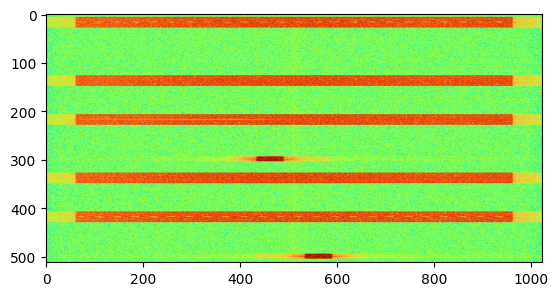

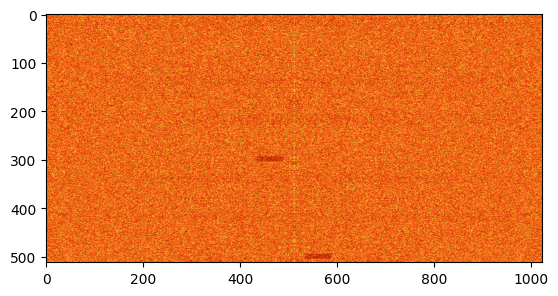

In [61]:
# ARG PARSE PARAMETERS
sample_dir = "/Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/"
save_dir = Path(sample_dir, "snr_noise_floor")
nfft = 1024
mini_batch_size = 1024*512
fft_count = None
save_data = False
skip_inference = True
min_freq = None
max_freq = None
    
if (min_freq is None and max_freq is not None) or (min_freq is not None and max_freq is None): 
    print("Error! If min_freq or max_freq is defined then both must be defined. Exiting.")
    exit()
if min_freq is not None and max_freq is not None: 
    custom_spectrogram = True
else: 
    custom_spectrogram = False

noverlap = 0 #nfft // 8
model = None
cmap = plt.get_cmap("turbo")


spectrogram_id = 0 
processed_files = []

wait_count = 0 
wait_time = 1
wait_count_limit = 5

while True:
    unprocessed_files = [
        basefilename
        for basefilename in sorted(os.listdir(sample_dir))
        if os.path.isfile(os.path.join(sample_dir, basefilename)) 
        and supported_filetype(basefilename)
        and basefilename not in processed_files
    ]

    # Process files
    if unprocessed_files:

        meta_data = {}

        for basefilename in unprocessed_files: 
            unprocessed_files.remove(basefilename)
            
            # Load samples 
            file_info = parse_filename(os.path.join(sample_dir, basefilename))
            if file_info is None: 
                continue
                
            samples = read_samples(
                file_info["filename"], 
                file_info["sample_dtype"], 
                file_info["sample_len"], 
                seek_bytes=0, 
                nfft=nfft, 
                fft_count=fft_count,
            )
            if samples is None:
                print("Continuing...")
                continue
            processed_files.append(basefilename)
            print(f"Recording duration: {len(samples)/file_info['sample_rate']} seconds")

            # DO BATCHING HERE 
            
            if mini_batch_size is None:
                mini_batch_size = len(samples)
            batch_id = 0
            
            for idx in tqdm(range(0, len(samples), mini_batch_size)): 
                sample_start_idx = idx
                sample_end_idx = idx+mini_batch_size
                sample_batch = samples[sample_start_idx:sample_end_idx]


                spectrogram_data, spectrogram_raw = spectrogram(
                    sample_batch, 
                    file_info["sample_rate"], 
                    nfft, 
                    noverlap, 
                    min_freq=min_freq, 
                    max_freq=max_freq, 
                    freq_center=file_info["freq_center"]
                )
                print(f"{np.max(spectrogram_data)=}, {np.min(spectrogram_data)=}")
                print(f"{np.max(spectrogram_raw)=}, {np.min(spectrogram_raw)=}")
                spectrogram_color = spectrogram_cmap(
                    spectrogram_data, 
                    cmap
                )
                
                plt.figure()
                plt.imshow(spectrogram_color)

                ### +AWGN

                avg_power_db = 10 * np.log10(np.mean(np.abs(sample_batch)**2))
                target_snr_db = -15
                target_noise_db = avg_power_db - target_snr_db

                # Convert to linear Watt units
                target_noise_watts = 10 ** (target_noise_db / 10)
                
                # Generate noise samples
                mean_noise = 0
                noise_volts = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(sample_batch))
                
                # Noise up the original signal (again) and plot
                sample_batch_noisy = sample_batch + noise_volts

                spectrogram_data, spectrogram_raw = spectrogram(
                    sample_batch_noisy, 
                    file_info["sample_rate"], 
                    nfft, 
                    noverlap, 
                    min_freq=min_freq, 
                    max_freq=max_freq, 
                    freq_center=file_info["freq_center"]
                )
                print(f"{np.max(spectrogram_data)=}, {np.min(spectrogram_data)=}")
                print(f"{np.max(spectrogram_raw)=}, {np.min(spectrogram_raw)=}")
                spectrogram_color = spectrogram_cmap(
                    spectrogram_data, 
                    cmap
                )
                plt.figure()
                plt.imshow(spectrogram_color)
                asdf
    else:
        print("Waiting for sample files to process...")
        time.sleep(wait_time)
        wait_count += 1
        if wait_count == wait_count_limit: 
            print(f"No samples found for {wait_time*wait_count_limit} seconds. Exiting.")
            break

np.max(spectrogram_data)=1.0, np.min(spectrogram_data)=0.0
np.max(spectrogram_raw)=141.29364404998685, np.min(spectrogram_raw)=7.694641096655482e-11


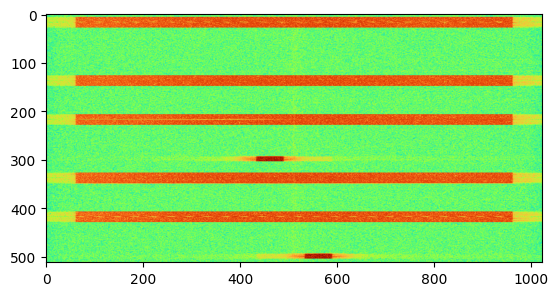

In [37]:
x_volts = sample_batch.copy()
x_watts = np.abs(sample_batch.copy())**2
# Set a target SNR
target_snr_db = 66
# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
# Noise up the original signal
y_volts = x_volts + noise_volts

spectrogram_data, spectrogram_raw = spectrogram(
    y_volts, 
    file_info["sample_rate"], 
    nfft, 
    noverlap, 
    min_freq=min_freq, 
    max_freq=max_freq, 
    freq_center=file_info["freq_center"]
)
print(f"{np.max(spectrogram_data)=}, {np.min(spectrogram_data)=}")
print(f"{np.max(spectrogram_raw)=}, {np.min(spectrogram_raw)=}")
spectrogram_color = spectrogram_cmap(
    spectrogram_data, 
    cmap
)
plt.figure()
plt.imshow(spectrogram_color)

In [22]:
x = sample_batch.copy()
avg_pwr = np.mean(np.abs(x)**2)
print(avg_pwr)
avg_pwr = np.var(x)
print(avg_pwr)

4862655.5
4862655.5


In [23]:
np.mean(x)

(-0.05223465-0.19347382j)

In [24]:
10*np.log10(4862655)

66.86873457947506

In [25]:
sample_batch

array([  0. +0.j,   0. +0.j,   0. +0.j, ...,  -9.-13.j, -13. +9.j, -14. +9.j], dtype=complex64)

In [8]:
# ARG PARSE PARAMETERS
sample_dir = "/Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/"
save_dir = Path(sample_dir, "gamutrf_data_test")
nfft = 1024
mini_batch_size = 1024*512
fft_count = None
save_data = True
skip_inference = True
min_freq = None
max_freq = None
    
if (min_freq is None and max_freq is not None) or (min_freq is not None and max_freq is None): 
    print("Error! If min_freq or max_freq is defined then both must be defined. Exiting.")
    exit()
if min_freq is not None and max_freq is not None: 
    custom_spectrogram = True
else: 
    custom_spectrogram = False

noverlap = 0 #nfft // 8
model = None
cmap = plt.get_cmap("turbo")


spectrogram_id = 0 
processed_files = []

wait_count = 0 
wait_time = 1
wait_count_limit = 5

while True:
    unprocessed_files = [
        basefilename
        for basefilename in sorted(os.listdir(sample_dir))
        if os.path.isfile(os.path.join(sample_dir, basefilename)) 
        and supported_filetype(basefilename)
        and basefilename not in processed_files
    ]

    # Process files
    if unprocessed_files:

        meta_data = {}

        for basefilename in unprocessed_files: 
            unprocessed_files.remove(basefilename)
            
            # Load samples 
            file_info = parse_filename(os.path.join(sample_dir, basefilename))
            if file_info is None: 
                continue
                
            samples = read_samples(
                file_info["filename"], 
                file_info["sample_dtype"], 
                file_info["sample_len"], 
                seek_bytes=0, 
                nfft=nfft, 
                fft_count=fft_count,
            )
            if samples is None:
                print("Continuing...")
                continue
            processed_files.append(basefilename)
            print(f"Recording duration: {len(samples)/file_info['sample_rate']} seconds")

            # DO BATCHING HERE 
            
            if mini_batch_size is None:
                mini_batch_size = len(samples)
            batch_id = 0
            
            for idx in tqdm(range(0, len(samples), mini_batch_size)): 
                sample_start_idx = idx
                sample_end_idx = idx+mini_batch_size
                sample_batch = samples[sample_start_idx:sample_end_idx]

                print(f"Batch duration: {len(sample_batch)/file_info['sample_rate']} seconds")
                
                spectrogram_data, spectrogram_raw = spectrogram(
                    sample_batch, 
                    file_info["sample_rate"], 
                    nfft, 
                    noverlap, 
                    min_freq=min_freq, 
                    max_freq=max_freq, 
                    freq_center=file_info["freq_center"]
                )
                spectrogram_color = spectrogram_cmap(
                    spectrogram_data, 
                    cmap
                )
    
                
                if save_data or not skip_inference: 

                    batchstr = ""
                    if mini_batch_size != len(samples): 
                        batchstr = f"_batch{batch_id}"
                        
                    savefilename = f"{basefilename}_id{spectrogram_id}{batchstr}"
                    
                    # Save spectrogram as .png
                    if save_data: 
                        spectrogram_img = Image.fromarray(spectrogram_color)
                        image_dir = Path(save_dir, "png")
                        image_dir.mkdir(parents=True, exist_ok=True)
                        image_path = image_dir / f"{savefilename}.png"
                        spectrogram_img.save(image_path)
                        meta_data["img_file"] = str(image_path)
                        print("Saved image to "+str(image_path))
            
                    # Run inference model
                    if not skip_inference:
                        if model is None: 
                            model = YOLO("/home/ltindall/ultralytics/runs/detect/yolov8s_exp_v05/weights/best.pt")
                        if spectrogram_id > 0: # bug in yolov8, name parameters is broken in predict()
                            model.predictor.save_dir = Path(save_dir, "predictions", savefilename) 
                        results = model.predict(source=spectrogram_color[:,:,::-1], conf=0.05, save=True, save_txt=True, save_conf=True, project=f"{save_dir}/predictions/", name=f"{savefilename}", exist_ok=True)
        
                    # Save metadata as .json 
                    meta_data["id"] = spectrogram_id
                    meta_data["nfft"] = nfft
                    meta_data["sample_start_idx"] = sample_start_idx
                    meta_data["sample_end_idx"] = sample_end_idx
                    meta_data["mini_batch_size"] = mini_batch_size
                    meta_data["sample_file"] = file_info
                    meta_dir = Path(save_dir, "metadata")
                    meta_dir.mkdir(parents=True, exist_ok=True)
                    json_object = json.dumps(meta_data, indent=4, cls=DtypeEncoder)
                    meta_data_path = meta_dir / f"{savefilename}.json"
                    with open(meta_data_path, "w") as outfile:
                        outfile.write(json_object)
                    print("Saved metadata to "+str(meta_data_path))
                batch_id += 1
                spectrogram_id += 1    

    else:
        print("Waiting for sample files to process...")
        time.sleep(wait_time)
        wait_count += 1
        if wait_count == wait_count_limit: 
            print(f"No samples found for {wait_time*wait_count_limit} seconds. Exiting.")
            break

Reading /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst
Recording duration: 1.024 seconds


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

Batch duration: 0.0256 seconds


  2%|█▌                                                              | 1/40 [00:00<00:04,  7.93it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id0_batch0.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id0_batch0.json
Batch duration: 0.0256 seconds


  5%|███▏                                                            | 2/40 [00:00<00:04,  7.98it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id1_batch1.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id1_batch1.json
Batch duration: 0.0256 seconds


  8%|████▊                                                           | 3/40 [00:00<00:04,  7.91it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id2_batch2.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id2_batch2.json
Batch duration: 0.0256 seconds


 10%|██████▍                                                         | 4/40 [00:00<00:04,  7.83it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id3_batch3.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id3_batch3.json
Batch duration: 0.0256 seconds


 12%|████████                                                        | 5/40 [00:00<00:04,  7.85it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id4_batch4.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id4_batch4.json
Batch duration: 0.0256 seconds


 15%|█████████▌                                                      | 6/40 [00:00<00:04,  7.96it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id5_batch5.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id5_batch5.json
Batch duration: 0.0256 seconds


 18%|███████████▏                                                    | 7/40 [00:00<00:04,  7.94it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id6_batch6.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id6_batch6.json
Batch duration: 0.0256 seconds


 20%|████████████▊                                                   | 8/40 [00:01<00:04,  8.00it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id7_batch7.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id7_batch7.json
Batch duration: 0.0256 seconds


 22%|██████████████▍                                                 | 9/40 [00:01<00:03,  8.01it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id8_batch8.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id8_batch8.json
Batch duration: 0.0256 seconds


 25%|███████████████▊                                               | 10/40 [00:01<00:03,  8.00it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id9_batch9.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id9_batch9.json
Batch duration: 0.0256 seconds


 28%|█████████████████▎                                             | 11/40 [00:01<00:03,  8.00it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id10_batch10.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id10_batch10.json
Batch duration: 0.0256 seconds


 30%|██████████████████▉                                            | 12/40 [00:01<00:03,  8.00it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id11_batch11.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id11_batch11.json
Batch duration: 0.0256 seconds


 32%|████████████████████▍                                          | 13/40 [00:01<00:03,  8.01it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id12_batch12.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id12_batch12.json
Batch duration: 0.0256 seconds


 35%|██████████████████████                                         | 14/40 [00:01<00:03,  8.02it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id13_batch13.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id13_batch13.json
Batch duration: 0.0256 seconds


 38%|███████████████████████▋                                       | 15/40 [00:01<00:03,  7.94it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id14_batch14.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id14_batch14.json
Batch duration: 0.0256 seconds


 40%|█████████████████████████▏                                     | 16/40 [00:02<00:03,  7.89it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id15_batch15.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id15_batch15.json
Batch duration: 0.0256 seconds


 42%|██████████████████████████▊                                    | 17/40 [00:02<00:02,  8.00it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id16_batch16.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id16_batch16.json
Batch duration: 0.0256 seconds


 45%|████████████████████████████▎                                  | 18/40 [00:02<00:02,  8.03it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id17_batch17.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id17_batch17.json
Batch duration: 0.0256 seconds


 48%|█████████████████████████████▉                                 | 19/40 [00:02<00:02,  7.93it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id18_batch18.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id18_batch18.json
Batch duration: 0.0256 seconds


 50%|███████████████████████████████▌                               | 20/40 [00:02<00:02,  7.86it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id19_batch19.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id19_batch19.json
Batch duration: 0.0256 seconds


 52%|█████████████████████████████████                              | 21/40 [00:02<00:02,  7.88it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id20_batch20.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id20_batch20.json
Batch duration: 0.0256 seconds


 55%|██████████████████████████████████▋                            | 22/40 [00:02<00:02,  7.96it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id21_batch21.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id21_batch21.json
Batch duration: 0.0256 seconds


 57%|████████████████████████████████████▏                          | 23/40 [00:02<00:02,  7.94it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id22_batch22.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id22_batch22.json
Batch duration: 0.0256 seconds


 60%|█████████████████████████████████████▊                         | 24/40 [00:03<00:01,  8.02it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id23_batch23.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id23_batch23.json
Batch duration: 0.0256 seconds


 62%|███████████████████████████████████████▍                       | 25/40 [00:03<00:01,  8.07it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id24_batch24.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id24_batch24.json
Batch duration: 0.0256 seconds


 65%|████████████████████████████████████████▉                      | 26/40 [00:03<00:01,  8.13it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id25_batch25.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id25_batch25.json
Batch duration: 0.0256 seconds


 68%|██████████████████████████████████████████▌                    | 27/40 [00:03<00:01,  8.16it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id26_batch26.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id26_batch26.json
Batch duration: 0.0256 seconds


 70%|████████████████████████████████████████████                   | 28/40 [00:03<00:01,  8.22it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id27_batch27.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id27_batch27.json
Batch duration: 0.0256 seconds


 72%|█████████████████████████████████████████████▋                 | 29/40 [00:03<00:01,  8.25it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id28_batch28.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id28_batch28.json
Batch duration: 0.0256 seconds


 75%|███████████████████████████████████████████████▎               | 30/40 [00:03<00:01,  8.23it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id29_batch29.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id29_batch29.json
Batch duration: 0.0256 seconds


 78%|████████████████████████████████████████████████▊              | 31/40 [00:03<00:01,  8.12it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id30_batch30.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id30_batch30.json
Batch duration: 0.0256 seconds


 80%|██████████████████████████████████████████████████▍            | 32/40 [00:03<00:00,  8.09it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id31_batch31.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id31_batch31.json
Batch duration: 0.0256 seconds


 82%|███████████████████████████████████████████████████▉           | 33/40 [00:04<00:00,  8.09it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id32_batch32.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id32_batch32.json
Batch duration: 0.0256 seconds


 85%|█████████████████████████████████████████████████████▌         | 34/40 [00:04<00:00,  8.13it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id33_batch33.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id33_batch33.json
Batch duration: 0.0256 seconds


 88%|███████████████████████████████████████████████████████▏       | 35/40 [00:04<00:00,  8.08it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id34_batch34.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id34_batch34.json
Batch duration: 0.0256 seconds


 90%|████████████████████████████████████████████████████████▋      | 36/40 [00:04<00:00,  8.08it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id35_batch35.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id35_batch35.json
Batch duration: 0.0256 seconds


 92%|██████████████████████████████████████████████████████████▎    | 37/40 [00:04<00:00,  8.09it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id36_batch36.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id36_batch36.json
Batch duration: 0.0256 seconds


 95%|███████████████████████████████████████████████████████████▊   | 38/40 [00:04<00:00,  8.11it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id37_batch37.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id37_batch37.json
Batch duration: 0.0256 seconds


 98%|█████████████████████████████████████████████████████████████▍ | 39/40 [00:04<00:00,  8.16it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id38_batch38.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id38_batch38.json
Batch duration: 0.0256 seconds


100%|███████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.04it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id39_batch39.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675088974_5735500000Hz_20480000sps.s16.zst_id39_batch39.json
Reading /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst


Recording duration: 1.024 seconds


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

Batch duration: 0.0256 seconds


  2%|█▌                                                              | 1/40 [00:00<00:05,  7.58it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id40_batch0.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id40_batch0.json
Batch duration: 0.0256 seconds


  5%|███▏                                                            | 2/40 [00:00<00:05,  7.23it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id41_batch1.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id41_batch1.json
Batch duration: 0.0256 seconds


  8%|████▊                                                           | 3/40 [00:00<00:04,  7.47it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id42_batch2.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id42_batch2.json
Batch duration: 0.0256 seconds


 10%|██████▍                                                         | 4/40 [00:00<00:04,  7.55it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id43_batch3.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id43_batch3.json
Batch duration: 0.0256 seconds


 12%|████████                                                        | 5/40 [00:00<00:04,  7.65it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id44_batch4.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id44_batch4.json
Batch duration: 0.0256 seconds


 15%|█████████▌                                                      | 6/40 [00:00<00:04,  7.62it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id45_batch5.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id45_batch5.json
Batch duration: 0.0256 seconds


 18%|███████████▏                                                    | 7/40 [00:00<00:04,  7.51it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id46_batch6.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id46_batch6.json
Batch duration: 0.0256 seconds


 20%|████████████▊                                                   | 8/40 [00:01<00:04,  7.59it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id47_batch7.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id47_batch7.json
Batch duration: 0.0256 seconds


 22%|██████████████▍                                                 | 9/40 [00:01<00:04,  7.56it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id48_batch8.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id48_batch8.json
Batch duration: 0.0256 seconds


 25%|███████████████▊                                               | 10/40 [00:01<00:04,  7.46it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id49_batch9.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id49_batch9.json
Batch duration: 0.0256 seconds


 28%|█████████████████▎                                             | 11/40 [00:01<00:03,  7.32it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id50_batch10.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id50_batch10.json
Batch duration: 0.0256 seconds


 30%|██████████████████▉                                            | 12/40 [00:01<00:03,  7.27it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id51_batch11.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id51_batch11.json
Batch duration: 0.0256 seconds


 32%|████████████████████▍                                          | 13/40 [00:01<00:03,  7.21it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id52_batch12.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id52_batch12.json
Batch duration: 0.0256 seconds


 35%|██████████████████████                                         | 14/40 [00:01<00:03,  7.20it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id53_batch13.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id53_batch13.json
Batch duration: 0.0256 seconds


 38%|███████████████████████▋                                       | 15/40 [00:02<00:03,  7.20it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id54_batch14.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id54_batch14.json
Batch duration: 0.0256 seconds


 40%|█████████████████████████▏                                     | 16/40 [00:02<00:03,  7.26it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id55_batch15.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id55_batch15.json
Batch duration: 0.0256 seconds


 42%|██████████████████████████▊                                    | 17/40 [00:02<00:03,  7.38it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id56_batch16.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id56_batch16.json
Batch duration: 0.0256 seconds


 45%|████████████████████████████▎                                  | 18/40 [00:02<00:02,  7.47it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id57_batch17.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id57_batch17.json
Batch duration: 0.0256 seconds


 48%|█████████████████████████████▉                                 | 19/40 [00:02<00:02,  7.50it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id58_batch18.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id58_batch18.json
Batch duration: 0.0256 seconds


 50%|███████████████████████████████▌                               | 20/40 [00:02<00:02,  7.51it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id59_batch19.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id59_batch19.json
Batch duration: 0.0256 seconds


 52%|█████████████████████████████████                              | 21/40 [00:02<00:02,  7.49it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id60_batch20.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id60_batch20.json
Batch duration: 0.0256 seconds


 55%|██████████████████████████████████▋                            | 22/40 [00:02<00:02,  7.56it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id61_batch21.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id61_batch21.json
Batch duration: 0.0256 seconds


 57%|████████████████████████████████████▏                          | 23/40 [00:03<00:02,  7.60it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id62_batch22.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id62_batch22.json
Batch duration: 0.0256 seconds


 60%|█████████████████████████████████████▊                         | 24/40 [00:03<00:02,  7.63it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id63_batch23.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id63_batch23.json
Batch duration: 0.0256 seconds


 62%|███████████████████████████████████████▍                       | 25/40 [00:03<00:01,  7.68it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id64_batch24.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id64_batch24.json
Batch duration: 0.0256 seconds


 65%|████████████████████████████████████████▉                      | 26/40 [00:03<00:01,  7.71it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id65_batch25.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id65_batch25.json
Batch duration: 0.0256 seconds


 68%|██████████████████████████████████████████▌                    | 27/40 [00:03<00:01,  7.58it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id66_batch26.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id66_batch26.json
Batch duration: 0.0256 seconds


 70%|████████████████████████████████████████████                   | 28/40 [00:03<00:01,  7.55it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id67_batch27.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id67_batch27.json
Batch duration: 0.0256 seconds


 72%|█████████████████████████████████████████████▋                 | 29/40 [00:03<00:01,  7.58it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id68_batch28.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id68_batch28.json
Batch duration: 0.0256 seconds


 75%|███████████████████████████████████████████████▎               | 30/40 [00:04<00:01,  7.55it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id69_batch29.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id69_batch29.json
Batch duration: 0.0256 seconds


 78%|████████████████████████████████████████████████▊              | 31/40 [00:04<00:01,  7.64it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id70_batch30.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id70_batch30.json
Batch duration: 0.0256 seconds


 80%|██████████████████████████████████████████████████▍            | 32/40 [00:04<00:01,  7.61it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id71_batch31.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id71_batch31.json
Batch duration: 0.0256 seconds


 82%|███████████████████████████████████████████████████▉           | 33/40 [00:04<00:01,  6.76it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id72_batch32.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id72_batch32.json
Batch duration: 0.0256 seconds


 85%|█████████████████████████████████████████████████████▌         | 34/40 [00:04<00:00,  7.11it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id73_batch33.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id73_batch33.json
Batch duration: 0.0256 seconds


 88%|███████████████████████████████████████████████████████▏       | 35/40 [00:04<00:00,  7.25it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id74_batch34.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id74_batch34.json
Batch duration: 0.0256 seconds


 90%|████████████████████████████████████████████████████████▋      | 36/40 [00:04<00:00,  7.30it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id75_batch35.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id75_batch35.json
Batch duration: 0.0256 seconds


 92%|██████████████████████████████████████████████████████████▎    | 37/40 [00:04<00:00,  7.50it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id76_batch36.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id76_batch36.json
Batch duration: 0.0256 seconds


 95%|███████████████████████████████████████████████████████████▊   | 38/40 [00:05<00:00,  7.51it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id77_batch37.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id77_batch37.json
Batch duration: 0.0256 seconds


 98%|█████████████████████████████████████████████████████████████▍ | 39/40 [00:05<00:00,  7.45it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id78_batch38.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id78_batch38.json
Batch duration: 0.0256 seconds


100%|███████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.45it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id79_batch39.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089063_5735500000Hz_20480000sps.s16.zst_id79_batch39.json
Reading /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst


Recording duration: 1.024 seconds


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

Batch duration: 0.0256 seconds


  2%|█▌                                                              | 1/40 [00:00<00:05,  7.70it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id80_batch0.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id80_batch0.json
Batch duration: 0.0256 seconds


  5%|███▏                                                            | 2/40 [00:00<00:04,  7.91it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id81_batch1.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id81_batch1.json
Batch duration: 0.0256 seconds


  8%|████▊                                                           | 3/40 [00:00<00:04,  7.96it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id82_batch2.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id82_batch2.json
Batch duration: 0.0256 seconds


 10%|██████▍                                                         | 4/40 [00:00<00:04,  7.89it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id83_batch3.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id83_batch3.json
Batch duration: 0.0256 seconds


 12%|████████                                                        | 5/40 [00:00<00:04,  7.99it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id84_batch4.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id84_batch4.json
Batch duration: 0.0256 seconds


 15%|█████████▌                                                      | 6/40 [00:00<00:04,  7.92it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id85_batch5.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id85_batch5.json
Batch duration: 0.0256 seconds


 18%|███████████▏                                                    | 7/40 [00:00<00:04,  7.96it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id86_batch6.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id86_batch6.json
Batch duration: 0.0256 seconds


 20%|████████████▊                                                   | 8/40 [00:01<00:04,  7.98it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id87_batch7.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id87_batch7.json
Batch duration: 0.0256 seconds


 22%|██████████████▍                                                 | 9/40 [00:01<00:03,  7.96it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id88_batch8.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id88_batch8.json
Batch duration: 0.0256 seconds


 25%|███████████████▊                                               | 10/40 [00:01<00:03,  7.96it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id89_batch9.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id89_batch9.json
Batch duration: 0.0256 seconds


 28%|█████████████████▎                                             | 11/40 [00:01<00:03,  8.03it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id90_batch10.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id90_batch10.json
Batch duration: 0.0256 seconds


 30%|██████████████████▉                                            | 12/40 [00:01<00:03,  7.98it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id91_batch11.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id91_batch11.json
Batch duration: 0.0256 seconds


 32%|████████████████████▍                                          | 13/40 [00:01<00:03,  7.86it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id92_batch12.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id92_batch12.json
Batch duration: 0.0256 seconds


 35%|██████████████████████                                         | 14/40 [00:01<00:03,  7.88it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id93_batch13.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id93_batch13.json
Batch duration: 0.0256 seconds


 38%|███████████████████████▋                                       | 15/40 [00:01<00:03,  7.93it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id94_batch14.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id94_batch14.json
Batch duration: 0.0256 seconds


 40%|█████████████████████████▏                                     | 16/40 [00:02<00:03,  7.89it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id95_batch15.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id95_batch15.json
Batch duration: 0.0256 seconds


 42%|██████████████████████████▊                                    | 17/40 [00:02<00:02,  7.89it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id96_batch16.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id96_batch16.json
Batch duration: 0.0256 seconds


 45%|████████████████████████████▎                                  | 18/40 [00:02<00:02,  7.79it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id97_batch17.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id97_batch17.json
Batch duration: 0.0256 seconds


 48%|█████████████████████████████▉                                 | 19/40 [00:02<00:02,  7.91it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id98_batch18.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id98_batch18.json
Batch duration: 0.0256 seconds


 50%|███████████████████████████████▌                               | 20/40 [00:02<00:02,  7.90it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id99_batch19.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id99_batch19.json
Batch duration: 0.0256 seconds


 52%|█████████████████████████████████                              | 21/40 [00:02<00:02,  7.77it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id100_batch20.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id100_batch20.json
Batch duration: 0.0256 seconds


 55%|██████████████████████████████████▋                            | 22/40 [00:02<00:02,  7.81it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id101_batch21.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id101_batch21.json
Batch duration: 0.0256 seconds


 57%|████████████████████████████████████▏                          | 23/40 [00:02<00:02,  7.92it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id102_batch22.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id102_batch22.json
Batch duration: 0.0256 seconds


 60%|█████████████████████████████████████▊                         | 24/40 [00:03<00:02,  7.80it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id103_batch23.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id103_batch23.json
Batch duration: 0.0256 seconds


 62%|███████████████████████████████████████▍                       | 25/40 [00:03<00:01,  7.86it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id104_batch24.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id104_batch24.json
Batch duration: 0.0256 seconds


 65%|████████████████████████████████████████▉                      | 26/40 [00:03<00:01,  7.80it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id105_batch25.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id105_batch25.json
Batch duration: 0.0256 seconds


 68%|██████████████████████████████████████████▌                    | 27/40 [00:03<00:01,  7.89it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id106_batch26.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id106_batch26.json
Batch duration: 0.0256 seconds


 70%|████████████████████████████████████████████                   | 28/40 [00:03<00:01,  7.94it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id107_batch27.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id107_batch27.json
Batch duration: 0.0256 seconds


 72%|█████████████████████████████████████████████▋                 | 29/40 [00:03<00:01,  7.94it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id108_batch28.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id108_batch28.json
Batch duration: 0.0256 seconds


 75%|███████████████████████████████████████████████▎               | 30/40 [00:03<00:01,  7.87it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id109_batch29.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id109_batch29.json
Batch duration: 0.0256 seconds


 78%|████████████████████████████████████████████████▊              | 31/40 [00:03<00:01,  7.86it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id110_batch30.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id110_batch30.json
Batch duration: 0.0256 seconds


 80%|██████████████████████████████████████████████████▍            | 32/40 [00:04<00:01,  7.94it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id111_batch31.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id111_batch31.json
Batch duration: 0.0256 seconds


 82%|███████████████████████████████████████████████████▉           | 33/40 [00:04<00:00,  7.94it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id112_batch32.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id112_batch32.json
Batch duration: 0.0256 seconds


 85%|█████████████████████████████████████████████████████▌         | 34/40 [00:04<00:00,  7.91it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id113_batch33.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id113_batch33.json
Batch duration: 0.0256 seconds


 88%|███████████████████████████████████████████████████████▏       | 35/40 [00:04<00:00,  7.91it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id114_batch34.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id114_batch34.json
Batch duration: 0.0256 seconds


 90%|████████████████████████████████████████████████████████▋      | 36/40 [00:04<00:00,  7.90it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id115_batch35.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id115_batch35.json
Batch duration: 0.0256 seconds


 92%|██████████████████████████████████████████████████████████▎    | 37/40 [00:04<00:00,  7.83it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id116_batch36.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id116_batch36.json
Batch duration: 0.0256 seconds


 95%|███████████████████████████████████████████████████████████▊   | 38/40 [00:04<00:00,  7.76it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id117_batch37.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id117_batch37.json
Batch duration: 0.0256 seconds


 98%|█████████████████████████████████████████████████████████████▍ | 39/40 [00:04<00:00,  7.78it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id118_batch38.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id118_batch38.json
Batch duration: 0.0256 seconds


100%|███████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.89it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id119_batch39.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089106_5735500000Hz_20480000sps.s16.zst_id119_batch39.json
Reading /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst


Recording duration: 1.024 seconds


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

Batch duration: 0.0256 seconds


  2%|█▌                                                              | 1/40 [00:00<00:05,  7.39it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id120_batch0.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id120_batch0.json
Batch duration: 0.0256 seconds


  5%|███▏                                                            | 2/40 [00:00<00:05,  7.56it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id121_batch1.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id121_batch1.json
Batch duration: 0.0256 seconds


  8%|████▊                                                           | 3/40 [00:00<00:04,  7.62it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id122_batch2.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id122_batch2.json
Batch duration: 0.0256 seconds


 10%|██████▍                                                         | 4/40 [00:00<00:04,  7.54it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id123_batch3.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id123_batch3.json
Batch duration: 0.0256 seconds


 12%|████████                                                        | 5/40 [00:00<00:04,  7.45it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id124_batch4.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id124_batch4.json
Batch duration: 0.0256 seconds


 15%|█████████▌                                                      | 6/40 [00:00<00:04,  7.49it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id125_batch5.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id125_batch5.json
Batch duration: 0.0256 seconds


 18%|███████████▏                                                    | 7/40 [00:00<00:04,  7.42it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id126_batch6.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id126_batch6.json
Batch duration: 0.0256 seconds


 20%|████████████▊                                                   | 8/40 [00:01<00:04,  7.42it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id127_batch7.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id127_batch7.json
Batch duration: 0.0256 seconds


 22%|██████████████▍                                                 | 9/40 [00:01<00:04,  7.39it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id128_batch8.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id128_batch8.json
Batch duration: 0.0256 seconds


 25%|███████████████▊                                               | 10/40 [00:01<00:04,  7.34it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id129_batch9.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id129_batch9.json
Batch duration: 0.0256 seconds


 28%|█████████████████▎                                             | 11/40 [00:01<00:03,  7.31it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id130_batch10.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id130_batch10.json
Batch duration: 0.0256 seconds


 30%|██████████████████▉                                            | 12/40 [00:01<00:03,  7.44it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id131_batch11.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id131_batch11.json
Batch duration: 0.0256 seconds


 32%|████████████████████▍                                          | 13/40 [00:01<00:03,  7.24it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id132_batch12.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id132_batch12.json
Batch duration: 0.0256 seconds


 35%|██████████████████████                                         | 14/40 [00:01<00:03,  7.26it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id133_batch13.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id133_batch13.json
Batch duration: 0.0256 seconds


 38%|███████████████████████▋                                       | 15/40 [00:02<00:03,  7.32it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id134_batch14.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id134_batch14.json
Batch duration: 0.0256 seconds


 40%|█████████████████████████▏                                     | 16/40 [00:02<00:03,  7.36it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id135_batch15.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id135_batch15.json
Batch duration: 0.0256 seconds


 42%|██████████████████████████▊                                    | 17/40 [00:02<00:03,  7.46it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id136_batch16.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id136_batch16.json
Batch duration: 0.0256 seconds


 45%|████████████████████████████▎                                  | 18/40 [00:02<00:02,  7.53it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id137_batch17.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id137_batch17.json
Batch duration: 0.0256 seconds


 48%|█████████████████████████████▉                                 | 19/40 [00:02<00:02,  7.51it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id138_batch18.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id138_batch18.json
Batch duration: 0.0256 seconds


 50%|███████████████████████████████▌                               | 20/40 [00:02<00:02,  7.59it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id139_batch19.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id139_batch19.json
Batch duration: 0.0256 seconds


 52%|█████████████████████████████████                              | 21/40 [00:02<00:02,  7.52it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id140_batch20.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id140_batch20.json
Batch duration: 0.0256 seconds


 55%|██████████████████████████████████▋                            | 22/40 [00:02<00:02,  7.56it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id141_batch21.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id141_batch21.json
Batch duration: 0.0256 seconds


 57%|████████████████████████████████████▏                          | 23/40 [00:03<00:02,  7.55it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id142_batch22.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id142_batch22.json
Batch duration: 0.0256 seconds


 60%|█████████████████████████████████████▊                         | 24/40 [00:03<00:02,  7.61it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id143_batch23.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id143_batch23.json
Batch duration: 0.0256 seconds


 62%|███████████████████████████████████████▍                       | 25/40 [00:03<00:01,  7.65it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id144_batch24.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id144_batch24.json
Batch duration: 0.0256 seconds


 65%|████████████████████████████████████████▉                      | 26/40 [00:03<00:01,  7.68it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id145_batch25.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id145_batch25.json
Batch duration: 0.0256 seconds


 68%|██████████████████████████████████████████▌                    | 27/40 [00:03<00:01,  7.66it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id146_batch26.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id146_batch26.json
Batch duration: 0.0256 seconds


 70%|████████████████████████████████████████████                   | 28/40 [00:03<00:01,  7.72it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id147_batch27.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id147_batch27.json
Batch duration: 0.0256 seconds


 72%|█████████████████████████████████████████████▋                 | 29/40 [00:03<00:01,  7.75it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id148_batch28.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id148_batch28.json
Batch duration: 0.0256 seconds


 75%|███████████████████████████████████████████████▎               | 30/40 [00:03<00:01,  7.68it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id149_batch29.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id149_batch29.json
Batch duration: 0.0256 seconds


 78%|████████████████████████████████████████████████▊              | 31/40 [00:04<00:01,  7.72it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id150_batch30.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id150_batch30.json
Batch duration: 0.0256 seconds


 80%|██████████████████████████████████████████████████▍            | 32/40 [00:04<00:01,  7.75it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id151_batch31.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id151_batch31.json
Batch duration: 0.0256 seconds


 82%|███████████████████████████████████████████████████▉           | 33/40 [00:04<00:00,  7.73it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id152_batch32.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id152_batch32.json
Batch duration: 0.0256 seconds


 85%|█████████████████████████████████████████████████████▌         | 34/40 [00:04<00:00,  7.56it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id153_batch33.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id153_batch33.json
Batch duration: 0.0256 seconds


 88%|███████████████████████████████████████████████████████▏       | 35/40 [00:04<00:00,  7.56it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id154_batch34.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id154_batch34.json
Batch duration: 0.0256 seconds


 90%|████████████████████████████████████████████████████████▋      | 36/40 [00:04<00:00,  7.61it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id155_batch35.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id155_batch35.json
Batch duration: 0.0256 seconds


 92%|██████████████████████████████████████████████████████████▎    | 37/40 [00:04<00:00,  7.64it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id156_batch36.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id156_batch36.json
Batch duration: 0.0256 seconds


 95%|███████████████████████████████████████████████████████████▊   | 38/40 [00:05<00:00,  7.62it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id157_batch37.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id157_batch37.json
Batch duration: 0.0256 seconds


 98%|█████████████████████████████████████████████████████████████▍ | 39/40 [00:05<00:00,  7.60it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id158_batch38.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id158_batch38.json
Batch duration: 0.0256 seconds


100%|███████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.54it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id159_batch39.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089044_5735500000Hz_20480000sps.s16.zst_id159_batch39.json
Reading /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst


Recording duration: 1.024 seconds


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

Batch duration: 0.0256 seconds


  2%|█▌                                                              | 1/40 [00:00<00:05,  7.29it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id160_batch0.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id160_batch0.json
Batch duration: 0.0256 seconds


  5%|███▏                                                            | 2/40 [00:00<00:05,  7.54it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id161_batch1.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id161_batch1.json
Batch duration: 0.0256 seconds


  8%|████▊                                                           | 3/40 [00:00<00:04,  7.56it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id162_batch2.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id162_batch2.json
Batch duration: 0.0256 seconds


 10%|██████▍                                                         | 4/40 [00:00<00:04,  7.62it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id163_batch3.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id163_batch3.json
Batch duration: 0.0256 seconds


 12%|████████                                                        | 5/40 [00:00<00:04,  7.63it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id164_batch4.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id164_batch4.json
Batch duration: 0.0256 seconds


 15%|█████████▌                                                      | 6/40 [00:00<00:04,  7.65it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id165_batch5.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id165_batch5.json
Batch duration: 0.0256 seconds


 18%|███████████▏                                                    | 7/40 [00:00<00:04,  7.64it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id166_batch6.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id166_batch6.json
Batch duration: 0.0256 seconds


 20%|████████████▊                                                   | 8/40 [00:01<00:04,  7.59it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id167_batch7.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id167_batch7.json
Batch duration: 0.0256 seconds


 22%|██████████████▍                                                 | 9/40 [00:01<00:04,  7.58it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id168_batch8.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id168_batch8.json
Batch duration: 0.0256 seconds


 25%|███████████████▊                                               | 10/40 [00:01<00:03,  7.54it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id169_batch9.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id169_batch9.json
Batch duration: 0.0256 seconds


 28%|█████████████████▎                                             | 11/40 [00:01<00:03,  7.45it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id170_batch10.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id170_batch10.json
Batch duration: 0.0256 seconds


 30%|██████████████████▉                                            | 12/40 [00:01<00:03,  7.32it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id171_batch11.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id171_batch11.json
Batch duration: 0.0256 seconds


 32%|████████████████████▍                                          | 13/40 [00:01<00:03,  7.37it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id172_batch12.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id172_batch12.json
Batch duration: 0.0256 seconds


 35%|██████████████████████                                         | 14/40 [00:01<00:03,  7.42it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id173_batch13.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id173_batch13.json
Batch duration: 0.0256 seconds


 38%|███████████████████████▋                                       | 15/40 [00:01<00:03,  7.47it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id174_batch14.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id174_batch14.json
Batch duration: 0.0256 seconds


 40%|█████████████████████████▏                                     | 16/40 [00:02<00:03,  7.50it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id175_batch15.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id175_batch15.json
Batch duration: 0.0256 seconds


 42%|██████████████████████████▊                                    | 17/40 [00:02<00:03,  7.49it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id176_batch16.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id176_batch16.json
Batch duration: 0.0256 seconds


 45%|████████████████████████████▎                                  | 18/40 [00:02<00:02,  7.55it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id177_batch17.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id177_batch17.json
Batch duration: 0.0256 seconds


 48%|█████████████████████████████▉                                 | 19/40 [00:02<00:02,  7.52it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id178_batch18.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id178_batch18.json
Batch duration: 0.0256 seconds


 50%|███████████████████████████████▌                               | 20/40 [00:02<00:02,  7.52it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id179_batch19.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id179_batch19.json
Batch duration: 0.0256 seconds


 52%|█████████████████████████████████                              | 21/40 [00:02<00:02,  7.67it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id180_batch20.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id180_batch20.json
Batch duration: 0.0256 seconds


 55%|██████████████████████████████████▋                            | 22/40 [00:02<00:02,  7.62it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id181_batch21.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id181_batch21.json
Batch duration: 0.0256 seconds


 57%|████████████████████████████████████▏                          | 23/40 [00:03<00:02,  7.60it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id182_batch22.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id182_batch22.json
Batch duration: 0.0256 seconds


 60%|█████████████████████████████████████▊                         | 24/40 [00:03<00:02,  7.61it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id183_batch23.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id183_batch23.json
Batch duration: 0.0256 seconds


 62%|███████████████████████████████████████▍                       | 25/40 [00:03<00:02,  7.46it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id184_batch24.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id184_batch24.json
Batch duration: 0.0256 seconds


 65%|████████████████████████████████████████▉                      | 26/40 [00:03<00:01,  7.46it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id185_batch25.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id185_batch25.json
Batch duration: 0.0256 seconds


 68%|██████████████████████████████████████████▌                    | 27/40 [00:03<00:01,  7.50it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id186_batch26.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id186_batch26.json
Batch duration: 0.0256 seconds


 70%|████████████████████████████████████████████                   | 28/40 [00:03<00:01,  7.56it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id187_batch27.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id187_batch27.json
Batch duration: 0.0256 seconds


 72%|█████████████████████████████████████████████▋                 | 29/40 [00:03<00:01,  7.66it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id188_batch28.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id188_batch28.json
Batch duration: 0.0256 seconds


 75%|███████████████████████████████████████████████▎               | 30/40 [00:03<00:01,  7.72it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id189_batch29.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id189_batch29.json
Batch duration: 0.0256 seconds


 78%|████████████████████████████████████████████████▊              | 31/40 [00:04<00:01,  7.67it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id190_batch30.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id190_batch30.json
Batch duration: 0.0256 seconds


 80%|██████████████████████████████████████████████████▍            | 32/40 [00:04<00:01,  7.64it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id191_batch31.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id191_batch31.json
Batch duration: 0.0256 seconds


 82%|███████████████████████████████████████████████████▉           | 33/40 [00:04<00:00,  7.62it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id192_batch32.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id192_batch32.json
Batch duration: 0.0256 seconds


 85%|█████████████████████████████████████████████████████▌         | 34/40 [00:04<00:00,  7.67it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id193_batch33.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id193_batch33.json
Batch duration: 0.0256 seconds


 88%|███████████████████████████████████████████████████████▏       | 35/40 [00:04<00:00,  7.60it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id194_batch34.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id194_batch34.json
Batch duration: 0.0256 seconds


 90%|████████████████████████████████████████████████████████▋      | 36/40 [00:04<00:00,  7.58it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id195_batch35.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id195_batch35.json
Batch duration: 0.0256 seconds


 92%|██████████████████████████████████████████████████████████▎    | 37/40 [00:04<00:00,  7.55it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id196_batch36.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id196_batch36.json
Batch duration: 0.0256 seconds


 95%|███████████████████████████████████████████████████████████▊   | 38/40 [00:05<00:00,  7.58it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id197_batch37.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id197_batch37.json
Batch duration: 0.0256 seconds


 98%|█████████████████████████████████████████████████████████████▍ | 39/40 [00:05<00:00,  7.58it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id198_batch38.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id198_batch38.json
Batch duration: 0.0256 seconds


100%|███████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.57it/s]

Saved image to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/png/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id199_batch39.png
Saved metadata to /Users/ltindall/data/gamutrf/gamutrf-arl/01_30_23/mini2/gamutrf_data_test/metadata/gamutrf_recording_ettus__gain40_1675089081_5735500000Hz_20480000sps.s16.zst_id199_batch39.json
Waiting for sample files to process...


Waiting for sample files to process...
Waiting for sample files to process...
Waiting for sample files to process...
Waiting for sample files to process...
No samples found for 5 seconds. Exiting.


In [4]:
print(f"Generated {spectrogram_id} spectrograms from {len(processed_files)} recordings.")

Generated 100 spectrograms from 5 recordings.


In [4]:
unprocessed_files

[]

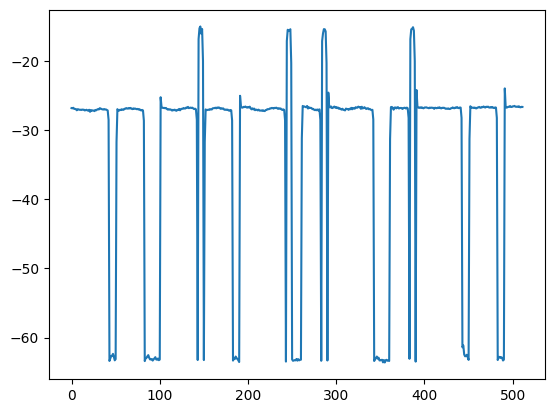

In [5]:
mini_batch = 2048
dbs = []
for idx in range(0, len(sample_batch), mini_batch): 
    a = np.mean(np.abs(sample_batch[idx:idx+mini_batch]/32768)**2)
    a = 10 * np.log10(a)
    dbs.append(a)

plt.figure()
plt.plot(dbs)
plt.show()

In [6]:
import seaborn as sns

/var/folders/4f/1fj0r82j165b2gq8w4sfghycjr5t43/T/ipykernel_48974/3003091721.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dbs, hist = False, kde = True)


<Axes: ylabel='Density'>

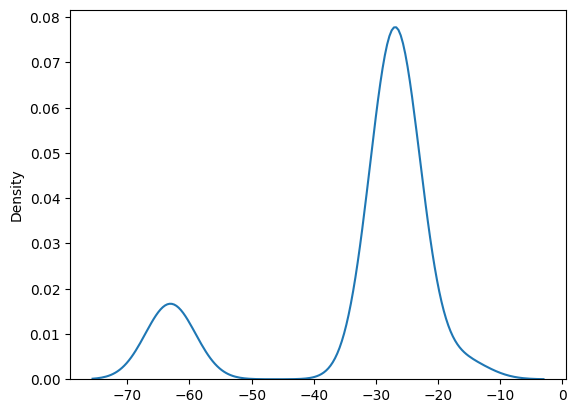

In [7]:
sns.distplot(dbs, hist = False, kde = True)
    

<Axes: ylabel='Count'>

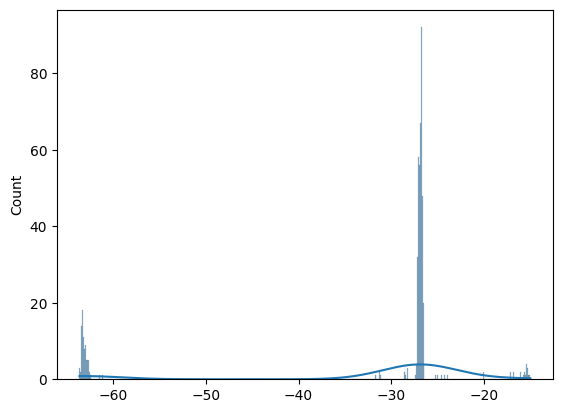

In [8]:
sns.histplot(dbs, kde=True)

In [9]:
spectrogram_color.shape

(1024, 1024, 3)

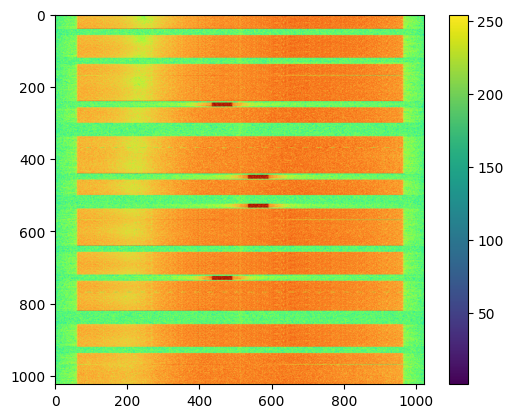

In [10]:
plt.figure()
plt.imshow(spectrogram_color)
plt.colorbar()
plt.show()

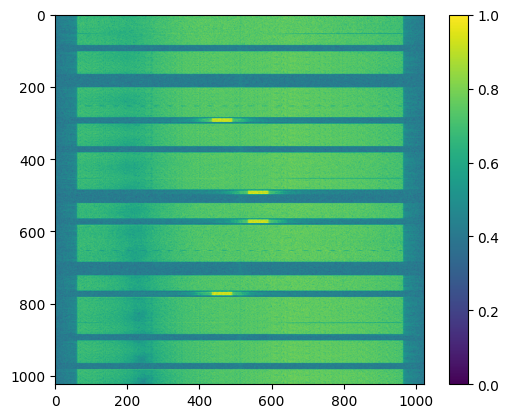

In [11]:
plt.figure()
plt.imshow(spectrogram_data)
plt.colorbar()
plt.show()

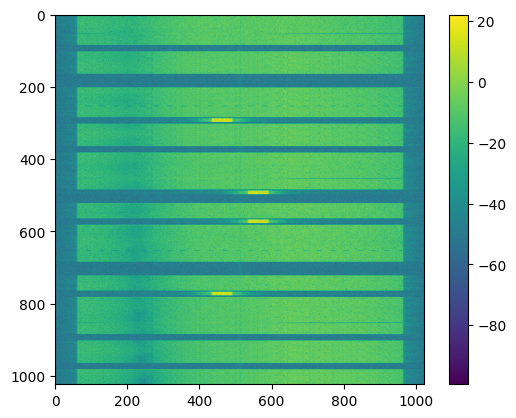

In [12]:
plt.figure()
plt.imshow(10*np.log10(spectrogram_raw))
plt.colorbar()
plt.show()

In [13]:
np.min(spectrogram_raw)

1.14360424e-10

In [14]:
spectrogram_raw.shape

(1024, 1024)

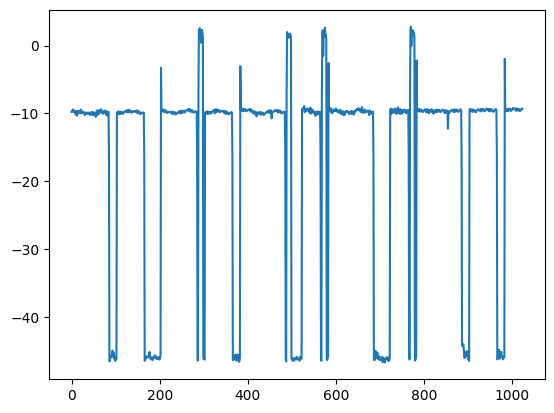

In [15]:
plt.figure()
plt.plot(10*np.log10(np.mean(spectrogram_raw, axis=1)))
plt.show()


In [16]:
np.max(np.mean(spectrogram_raw, axis=1))

1.9151754

In [17]:
512*2048

1048576

In [18]:
1024*1024

1048576